In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from lmfit import Model

In [3]:
# Variables  NEW!!!

cv = pd.DataFrame()
l = pd.DataFrame()
d = pd.DataFrame()
cap = pd.DataFrame()
eff = pd.DataFrame()
eis_df = pd.DataFrame()
pitt_df = pd.DataFrame()

final_results = {}

F = 96485 # C/mol
col_dep = ['Time (s)', 'Potential vs Ag/AgCl (V)', 'Current (A)', 'Charge (C)']
col_cv = ['Potential vs Li$^+$/Li (V)', 'Current (A)', 'Charge (C)', 'Time (s)', 'Current Density ($\mu$A/cm$^2$)', 'Scan']
col = ['Time', 'Time (s)', 'Current (μA)', 'Potential vs Li$^+$/Li (V)'] # 'Current Density (µA/cm$^2$)'
col2 = [col[3], 'D (cm$^2$/s)', '$\Delta$Q', 'Cs - Co (mol/cm$^3$)']
col_iv = ['Potential applied (V)', 'Current (A)', 'Time (s)']
potentials = ['{:.2f}'.format(round(i, 4))  for i in np.arange(3.90, 4.20, 0.05)]
formatter_0 = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e3))
formatter = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e6))
formatter_1 = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e4))
palette = 'BuPu'

# Set up files for procedure 'Galv_Cyc_LMO_1C_Final_EIS_20230724.nox'

def setup_files(path):

    files = [os.path.join(path, i) for i in os.listdir(path)]
    folders = ['CV', 'lith', 'delith', 'EIS']
    
    for i in folders:
        if not os.path.exists(os.path.join(path, i)):
            os.mkdir(os.path.join(path, i))

    if not os.path.exists(os.path.join(path, 'EIS', 'Relaxis')):
        os.mkdir(os.path.join(path, 'EIS', 'Relaxis'))
        
    for i in os.listdir(path):
        if 'EIS_' in i:
            os.rename(os.path.join(path, i), os.path.join(path, 'EIS', i))
            
    for i in os.listdir(os.path.join(path, 'EIS')):
        if 'relaxis' in i:
            os.rename(os.path.join(path, 'EIS', i), os.path.join(path, 'EIS', 'Relaxis', i))

    for i in os.listdir(path):
        if '_lith_' in i:
            os.rename(os.path.join(path, i), os.path.join(path, 'lith', i))
        elif '_delith' in i:
            os.rename(os.path.join(path, i), os.path.join(path, 'delith', i))
        elif i != 'README.txt' and len(i) > 7:
            os.rename(os.path.join(path, i), os.path.join(path, 'CV', i))
            
    for file_path in [os.path.join(os.path.join(path, 'EIS', 'Relaxis'), i) for i in os.listdir(os.path.join(path, 'EIS', 'Relaxis'))]:
        if '_relaxis' in file_path:
            # Extract the directory and filename from the file path
            directory, filename = os.path.split(file_path)
            
            # Extract the numeric part from the filename (assuming it's the last part before '_relaxis.txt')
            numeric_part = filename.split('_relaxis.txt')[0].split('EIS_')[-1]
            
            # Convert the numeric part to a float and format it to have 2 decimals
            numeric_with_two_decimals = '{:.2f}'.format(float(numeric_part))
            
            # Create the new filename by replacing the numeric part
            new_filename = filename.replace(numeric_part, numeric_with_two_decimals)
            
            # Create the new file path
            new_file_path = os.path.join(directory, new_filename)
        
            # # Rename the file
            if file_path != new_file_path:
                
                os.rename(file_path, new_file_path)
                print(f"Renamed: {file_path} => {new_file_path}")
                
    #add zero to cycles to have them sorted
    for file_path in [os.path.join(path, 'lith', i) for i in os.listdir(os.path.join(path, 'lith')) if i != 'README.txt']:
        directory, filename = os.path.split(file_path)
        numeric_part = filename.split('_')[-1].split('.txt')[0]
        numeric_two_decimals = '{:02d}'.format(int(numeric_part))
    
        new_filename =filename[:-7] + filename[-7:-4].replace(numeric_part, numeric_two_decimals) + '.txt'  # filename.replace(numeric_part, numeric_two_decimals)
        new_file_path = os.path.join(directory, new_filename)
    
        if file_path != new_file_path:
                
            os.rename(file_path, new_file_path)
            print(f"Renamed: {file_path} => {new_file_path}")
            
    for file_path in [os.path.join(path, 'delith', i) for i in os.listdir(os.path.join(path, 'delith')) if i != 'README.txt']:
        directory, filename = os.path.split(file_path)
        numeric_part = filename.split('_')[-1].split('.txt')[0]
        numeric_two_decimals = '{:02d}'.format(int(numeric_part))

        new_filename =filename[:-7] + filename[-7:-4].replace(numeric_part, numeric_two_decimals) + '.txt'  # filename.replace(numeric_part, numeric_two_decimals)
        new_file_path = os.path.join(directory, new_filename)

        if file_path != new_file_path:            
            os.rename(file_path, new_file_path)
            print(f"Renamed: {file_path} => {new_file_path}")
    
    # For PITT
    
    for filename in os.listdir(os.path.join(os.path.dirname(path), 'PITT')):
        
        # Extract the numeric part from the filename
        numeric_part = filename.split('_')[-1].split('.txt')[0]
    
    # # Convert the numeric part to a float and format it to have 2 decimals
        numeric_with_two_decimals = '{:.2f}'.format(float(numeric_part))
        
    # # Create the new filename by replacing the numeric part
        new_filename = filename.replace(numeric_part, numeric_with_two_decimals)
    
    # # Create the new file path
        new_file_path = os.path.join( os.path.join(os.path.dirname(path), 'PITT'), new_filename)

    # # # Rename the file
        if os.path.join(os.path.join(os.path.dirname(path), 'PITT'), filename) != new_file_path:
            os.rename(os.path.join(os.path.join(os.path.dirname(path), 'PITT'), filename), new_file_path)
            print(f"Renamed: {os.path.join(os.path.join(os.path.dirname(path), 'PITT'), filename)} => {new_file_path}")
       
# Methods
       
def cc(path, area, thickness, sample):
    
    cv_path = os.path.join(path, 'CV')
    lith_path = os.path.join(path, 'lith')
    delith_path = os.path.join(path, 'delith')
    cv_df = pd.DataFrame()
    
    for i in sorted(os.listdir(cv_path), reverse=True): # sorted to get initial first
        f = os.path.join(cv_path, i)
        df = pd.read_csv(f, sep = ';', skiprows = 1, names = col_cv)
        df['Current_density_calc'] = df[col_cv[1]] / area
        if '_Initial_' in i:
            df['CV'] = 'Initial'
        else:
            df['CV'] = 'Final'
        cv_df = pd.concat([cv_df, df], ignore_index=True)
        
    lithiation = pd.DataFrame()
    delithiation = pd.DataFrame()
    capacity_l = pd.DataFrame(columns = ['Capacity (mAh/cm$^3$)', 'Cycle', 'L/D'])
    capacity_d = pd.DataFrame(columns = ['Capacity (mAh/cm$^3$)', 'Cycle', 'L/D'])
    efficiency = pd.DataFrame()
    l = [os.path.join(lith_path, i) for i in os.listdir(lith_path)]
    n = 1
    for i in l:
        df = pd.read_csv(i, sep = ';')
        df = df.rename(columns={'WE(1).Potential (V)': col_cv[0], 'Capacity (mAh/cm3)': 'Capacity (mAh/cm$^3$)'})
        df['Cycle'] =  str(n) ### string or int
        df['Capacity_calc'] = -df['WE(1).Charge (C)'] /3.6 / (area * 1e-7 * thickness)
        lithiation = pd.concat([lithiation, df], ignore_index=True)
        capacity_l.loc[n] = (max(df['Capacity_calc']), n, 'Lithiation')
        n += 1
    
    d = [os.path.join(delith_path, i) for i in os.listdir(delith_path)]
    n = 1
    for i in d:
        df = pd.read_csv(i, sep = ';')
        df = df.rename(columns={'WE(1).Potential (V)': col_cv[0], 'Capacity (mAh/cm3)': 'Capacity (mAh/cm$^3$)'})
        df['Cycle'] =  n #str(n) ### string or int
        df['Capacity_calc'] = df['WE(1).Charge (C)'] /3.6 / (area * 1e-7 * thickness)
        delithiation = pd.concat([delithiation, df], ignore_index=True)
        capacity_d.loc[n] = (max(df['Capacity_calc']), n, 'Delithiation')
        n += 1
        
    capacity = pd.concat([capacity_l], ignore_index=True) #, capacity_d
    efficiency['Efficiency (%)'] = capacity_l['Capacity (mAh/cm$^3$)'] / capacity_d['Capacity (mAh/cm$^3$)'] * 100
    efficiency['Cycle'] = capacity_l['Cycle']
    # ###
    results = [cv_df, lithiation, delithiation, capacity, efficiency]#, eff]#, efficiency]
    for i in results:
        i['Sample'] = sample
    # ###

    return results#results #cv_df, lithiation, delithiation, capacity, efficiency

def eis(path, sample):
    
    col = ["Frequency (Hz)", "Z'", "-Z''", "Fit Frequency (Hz)", "Fit Z'", "Fit -Z''" ]
    
    path = os.path.join(path, 'EIS', 'Relaxis')
    files = [os.path.join(path, i) for i in os.listdir(path)]
    eis_data = pd.DataFrame()
    spectra = pd.DataFrame()
    m = 0
    for i in files:
        if 'Fit' in i:
            df = pd.read_csv(i, sep = '\t', skiprows = 2)
            df = df.rename(columns={'FreeVariable' : col_cv[0], 
                                    'Resistance 1: value' : 'Electrolyte Resistance ($\Omega$)', 
                                    'Resistance 2: value' : 'Charge Transfer Resistance ($\Omega$)',
                                    'CPE Q 1: value' : 'Double Layer Capacitance ($\mu$F)'})
            eis_data = pd.concat([eis_data, df], ignore_index=True)
            

        if 'Spectra' in i:
            df_s = pd.read_csv(i, skiprows=4, sep = '\t', names=col)

            df_s[col[2]] = -df_s[col[2]]
            df_s[col[5]] = -df_s[col[5]]
            df_s[col_cv[0]] = potentials[m]
            spectra = pd.concat([spectra, df_s], ignore_index=True)
            m += 1
            
    #     k += 1
    eis_data['Sample'] = sample
    spectra['Sample'] = sample
    eis = [eis_data, spectra]
    return eis #eis_data, spectra

def pitt(path, area, thickness, skip, sample):
    path = os.path.join(os.path.dirname(path), 'PITT')
    thickness = thickness * 1e-7
# PITT Model to fit
    def PITT(t, delta_q, D, i_b): #t, S, C, D, L ):
        # return ((2 *F * S * C * D)/L) * np.exp(-(np.pi**2 * D * t) / (4 * L ** 2))
        return (2 * delta_q * D / (thickness ** 2)) * np.exp(-((np.pi ** 2) * D * t / (4 * (thickness** 2)))) + i_b
    gmodel = Model(PITT)
    params = gmodel.make_params() 
    params['D'].set(value = 1e-10, min = 1e-20, max = 1e-5)
    # params['L'].set(value = 80e-7, vary = False)
    params['delta_q'].set(value = 0.1, min = 1e-22)
    params['i_b'].set(value = 3e-7, min = 0)

    #Data Analysis
    # def pitt_data(path, area, thickness, skip, sample):
    data = pd.DataFrame()
    fit_vals = pd.DataFrame(columns = col2)
    fit_reports = []
    files = [os.path.join(path, i) for i in os.listdir(path)]
    n = 0
    for i in files:
        df = pd.read_csv(i, sep = ';', skiprows = 1, names = col,  engine = 'python', skipfooter = skip) #4000
        fit = gmodel.fit(df[col[2]], params, t = df[col[1]])
        df['Step'] = i[-8:-4]
        df['Fit'] = fit.best_fit
        data = pd.concat([data, df], ignore_index = True)
        fit_reports.append(fit.fit_report())
        fit_vals.loc[n] = (float(i[-8:-4]), fit.values['D'], fit.values['delta_q'], fit.values['delta_q']/(F * area * thickness))
        n += 1
    data['Sample'] = sample
    fit_vals['Sample'] = sample
    results = [data, fit_vals, fit_reports]
    return results

def compare(results, add_eis_df, add_pitt_df, add):
    global cv, l, d, cap, eff, eis_df, pitt_df
    if add == True:
        cv = pd.concat([cv, results[0]], ignore_index = True)
        l = pd.concat([l, results[1]], ignore_index = True)
        d = pd.concat([d, results[2]], ignore_index = True)
        cap = pd.concat([cap, results[3]], ignore_index = True)
        eff = pd.concat([eff, results[4]], ignore_index = True)
        eis_df = pd.concat([eis_df, add_eis_df[0]], ignore_index = True)
        pitt_df = pd.concat([pitt_df, add_pitt_df[1]], ignore_index = True)

def compare1(results, add):
    global cv, l, d, cap, eff
    if add == True:
        cv = pd.concat([cv, results[0]], ignore_index = True)
        l = pd.concat([l, results[1]], ignore_index = True)
        d = pd.concat([d, results[2]], ignore_index = True)
        cap = pd.concat([cap, results[3]], ignore_index = True)
        eff = pd.concat([eff, results[4]], ignore_index = True)
        # eis_df = pd.concat([eis_df, add_eis_df[0]], ignore_index = True)
        # pitt_df = pd.concat([pitt_df, add_pitt_df[1]], ignore_index = True)

def cc_plot(cc_df, sample, dpi):
    # Plots
    fig, ax = plt.subplots(1, 2, figsize = (15,5), dpi = dpi)
    # sns.scatterplot(data = cc_df[0], x = col_cv[0], y = col_cv[4], edgecolor = None, s =1, ax = ax[0], hue = 'CV', palette = palette)
    sns.scatterplot(data = cc_df[0], x = col_cv[0], y = 'Current_density_calc', edgecolor = None, s =1, ax = ax[0], hue = 'CV', palette = palette)
    ax[0].set_ylabel(col_cv[4])
    sns.lineplot(data = cc_df[1], x = 'Capacity_calc', y = col_cv[0], hue = 'Cycle', palette = palette)
    sns.lineplot(data = cc_df[2], x = 'Capacity_calc', y = col_cv[0], hue = 'Cycle', legend = False, palette = palette )
    ax[0].yaxis.set_major_formatter(formatter)
    ax[1].set_xlabel('Capacity (mAh/cm$^3$)')
    fig.suptitle(sample)
    

    fig, ax = plt.subplots(1, 2, figsize = (15,5), dpi = dpi)
    sns.scatterplot(data = cc_df[3], x = 'Cycle', y = 'Capacity (mAh/cm$^3$)', hue = 'L/D', palette=palette, ax = ax[0])
    sns.scatterplot(data = cc_df[4], x = 'Cycle', y = 'Efficiency (%)', ax = ax[1])

def eis_plot(eis_df, dpi):
    fig, ax = plt.subplots(dpi = dpi)
    sns.barplot(data = eis_df[0], x = 'Potential vs Li$^+$/Li (V)', y = 'Charge Transfer Resistance ($\Omega$)', palette = palette)
    
def pitt_plot(df, sample):
    fig, ax = plt.subplots(2,2, dpi =200, figsize = (15,10))
    sns.scatterplot(data = df[0], x = col[0], y = col[3], edgecolor = None, ax = ax[0,0], s = 1)
    sns.scatterplot(data = df[0], x = col[0], y = col[2], edgecolor = None, ax = ax[0,1], s = 2)
    sns.scatterplot(data = df[1], x = col2[0], y = col2[1], ax = ax[1,0])
    sns.scatterplot(data = df[1], x = col2[0], y = col2[3])
    ax[0,1].yaxis.set_major_formatter(formatter)
    ax[1,0].set_yscale('log')
    # ax[1,0].set_ylim(2e-12, 2e-10)
    fig.suptitle(sample)

In [4]:
# # Variables

# cv = pd.DataFrame()
# l = pd.DataFrame()
# d = pd.DataFrame()
# cap = pd.DataFrame()
# eff = pd.DataFrame()
# eis_df = pd.DataFrame()
# pitt_df = pd.DataFrame()
# # compare_df = [cv, l, d, cap, eff, eis_df, pitt_df]


# F = 96485 # C/mol
# col_dep = ['Time (s)', 'Potential vs Ag/AgCl (V)', 'Current (A)', 'Charge (C)']
# col_cv = ['Potential vs Li$^+$/Li (V)', 'Current (A)', 'Charge (C)', 'Time (s)', 'Current Density ($\mu$A/cm$^2$)', 'Scan']
# col = ['Time', 'Time (s)', 'Current (μA)', 'Potential vs Li$^+$/Li (V)'] # 'Current Density (µA/cm$^2$)'
# col2 = [col[3], 'D (cm$^2$/s)', '$\Delta$Q', 'Cs - Co (mol/cm$^3$)']
# potentials = ['{:.2f}'.format(round(i, 4))  for i in np.arange(3.90, 4.20, 0.05)]
# formatter_0 = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e3))
# formatter = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e6))
# palette = 'cividis'

# # Set up files for procedure 'Galv_Cyc_LMO_1C_Final_EIS_20230724.nox'

# def setup_files(path):

#     files = [os.path.join(path, i) for i in os.listdir(path)]
#     folders = ['CV', 'lith', 'delith', 'EIS']
    
#     for i in folders:
#         if not os.path.exists(os.path.join(path, i)):
#             os.mkdir(os.path.join(path, i))

#     if not os.path.exists(os.path.join(path, 'EIS', 'Relaxis')):
#         os.mkdir(os.path.join(path, 'EIS', 'Relaxis'))
        
#     for i in os.listdir(path):
#         if 'EIS_' in i:
#             os.rename(os.path.join(path, i), os.path.join(path, 'EIS', i))
            
#     for i in os.listdir(os.path.join(path, 'EIS')):
#         if 'relaxis' in i:
#             os.rename(os.path.join(path, 'EIS', i), os.path.join(path, 'EIS', 'Relaxis', i))

#     for i in os.listdir(path):
#         if '_lith_' in i:
#             os.rename(os.path.join(path, i), os.path.join(path, 'lith', i))
#         elif '_delith' in i:
#             os.rename(os.path.join(path, i), os.path.join(path, 'delith', i))
#         elif i != 'README.txt' and len(i) > 7:
#             os.rename(os.path.join(path, i), os.path.join(path, 'CV', i))
            
#     for file_path in [os.path.join(os.path.join(path, 'EIS', 'Relaxis'), i) for i in os.listdir(os.path.join(path, 'EIS', 'Relaxis'))]:
#         if '_relaxis' in file_path:
#             # Extract the directory and filename from the file path
#             directory, filename = os.path.split(file_path)
            
#             # Extract the numeric part from the filename (assuming it's the last part before '_relaxis.txt')
#             numeric_part = filename.split('_relaxis.txt')[0].split('EIS_')[-1]
            
#             # Convert the numeric part to a float and format it to have 2 decimals
#             numeric_with_two_decimals = '{:.2f}'.format(float(numeric_part))
            
#             # Create the new filename by replacing the numeric part
#             new_filename = filename.replace(numeric_part, numeric_with_two_decimals)
            
#             # Create the new file path
#             new_file_path = os.path.join(directory, new_filename)
        
#             # # Rename the file
#             if file_path != new_file_path:
                
#                 os.rename(file_path, new_file_path)
#                 print(f"Renamed: {file_path} => {new_file_path}")
    
#     # For PITT
    
#     for filename in os.listdir(os.path.join(os.path.dirname(path), 'PITT')):
        
#         # Extract the numeric part from the filename
#         numeric_part = filename.split('_')[-1].split('.txt')[0]
    
#     # # Convert the numeric part to a float and format it to have 2 decimals
#         numeric_with_two_decimals = '{:.2f}'.format(float(numeric_part))
        
#     # # Create the new filename by replacing the numeric part
#         new_filename = filename.replace(numeric_part, numeric_with_two_decimals)
    
#     # # Create the new file path
#         new_file_path = os.path.join( os.path.join(os.path.dirname(path), 'PITT'), new_filename)

#     # # # Rename the file
#         if os.path.join(os.path.join(os.path.dirname(path), 'PITT'), filename) != new_file_path:
#             os.rename(os.path.join(os.path.join(os.path.dirname(path), 'PITT'), filename), new_file_path)
#             print(f"Renamed: {os.path.join(os.path.join(os.path.dirname(path), 'PITT'), filename)} => {new_file_path}")
       
# # Methods
       
# def cc(path, area, thickness, sample):
    
#     cv_path = os.path.join(path, 'CV')
#     lith_path = os.path.join(path, 'lith')
#     delith_path = os.path.join(path, 'delith')
#     cv_df = pd.DataFrame()
    
#     for i in sorted(os.listdir(cv_path), reverse=True): # sorted to get initial first
#         f = os.path.join(cv_path, i)
#         df = pd.read_csv(f, sep = ';', skiprows = 1, names = col_cv)
#         if '_Initial_' in i:
#             df['CV'] = 'Initial'
#         else:
#             df['CV'] = 'Final'
#         cv_df = pd.concat([cv_df, df], ignore_index=True)
        
#     lithiation = pd.DataFrame()
#     delithiation = pd.DataFrame()
#     capacity_l = pd.DataFrame(columns = ['Capacity (mAh/cm$^3$)', 'Cycle', 'L/D'])
#     capacity_d = pd.DataFrame(columns = ['Capacity (mAh/cm$^3$)', 'Cycle', 'L/D'])
#     efficiency = pd.DataFrame()
#     l = [os.path.join(lith_path, i) for i in os.listdir(lith_path)]
#     l = l.sort()
#     print(l)
#     n = 1
#     for i in l:
#         df = pd.read_csv(i, sep = ';')
#         df = df.rename(columns={'WE(1).Potential (V)': col_cv[0], 'Capacity (mAh/cm3)': 'Capacity (mAh/cm$^3$)'})
#         df['Cycle'] =  str(n) ### string or int
#         df['Capacity_calc'] = -df['WE(1).Charge (C)'] /3.6 / (area * 1e-7 * thickness)
#         lithiation = pd.concat([lithiation, df], ignore_index=True)
#         capacity_l.loc[n] = (max(df['Capacity_calc']), n, 'Lithiation')
#         n += 1
    
#     d = [os.path.join(delith_path, i) for i in os.listdir(delith_path)]
#     n = 1
#     for i in d:
#         df = pd.read_csv(i, sep = ';')
#         df = df.rename(columns={'WE(1).Potential (V)': col_cv[0], 'Capacity (mAh/cm3)': 'Capacity (mAh/cm$^3$)'})
#         df['Cycle'] =  n #str(n) ### string or int
#         df['Capacity_calc'] = df['WE(1).Charge (C)'] /3.6 / (area * 1e-7 * thickness)
#         delithiation = pd.concat([delithiation, df], ignore_index=True)
#         capacity_d.loc[n] = (max(df['Capacity_calc']), n, 'Delithiation')
#         n += 1
        
#     capacity = pd.concat([capacity_d], ignore_index=True) #, capacity_d
#     efficiency['Efficiency (%)'] = capacity_l['Capacity (mAh/cm$^3$)'] / capacity_d['Capacity (mAh/cm$^3$)'] * 100
#     efficiency['Cycle'] = capacity_l['Cycle']
#     # ###
#     results = [cv_df, lithiation, delithiation, capacity, efficiency]#, eff]#, efficiency]
#     for i in results:
#         i['Sample'] = sample
#     # ###

#     return results#results #cv_df, lithiation, delithiation, capacity, efficiency

# def eis(path, sample):
    
#     col = ["Frequency (Hz)", "Z'", "-Z''", "Fit Frequency (Hz)", "Fit Z'", "Fit -Z''" ]
    
#     path = os.path.join(path, 'EIS', 'Relaxis')
#     files = [os.path.join(path, i) for i in os.listdir(path)]
#     eis_data = pd.DataFrame()
#     spectra = pd.DataFrame()
#     m = 0
#     for i in files:
#         if 'Fit' in i:
#             df = pd.read_csv(i, sep = '\t', skiprows = 2)
#             df = df.rename(columns={'FreeVariable' : col_cv[0], 
#                                     'Resistance 1: value' : 'Electrolyte Resistance ($\Omega$)', 
#                                     'Resistance 2: value' : 'Charge Transfer Resistance ($\Omega$)',
#                                     'CPE Q 1: value' : 'Double Layer Capacitance ($\mu$F)'})
#             eis_data = pd.concat([eis_data, df], ignore_index=True)
            

#         if 'Spectra' in i:
#             df_s = pd.read_csv(i, skiprows=4, sep = '\t', names=col)

#             df_s[col[2]] = -df_s[col[2]]
#             df_s[col[5]] = -df_s[col[5]]
#             df_s[col_cv[0]] = potentials[m]
#             spectra = pd.concat([spectra, df_s], ignore_index=True)
#             m += 1
            
#     #     k += 1
#     eis_data['Sample'] = sample
#     spectra['Sample'] = sample
#     eis = [eis_data, spectra]
#     return eis #eis_data, spectra

# def pitt(path, area, thickness, skip, sample):
#     path = os.path.join(os.path.dirname(path), 'PITT')
#     thickness = thickness * 1e-7
# # PITT Model to fit
#     def PITT(t, delta_q, D, i_b): #t, S, C, D, L ):
#         # return ((2 *F * S * C * D)/L) * np.exp(-(np.pi**2 * D * t) / (4 * L ** 2))
#         return (2 * delta_q * D / (thickness ** 2)) * np.exp(-((np.pi ** 2) * D * t / (4 * (thickness** 2)))) + i_b
#     gmodel = Model(PITT)
#     params = gmodel.make_params() 
#     params['D'].set(value = 1e-10, min = 1e-20, max = 1e-5)
#     # params['L'].set(value = 80e-7, vary = False)
#     params['delta_q'].set(value = 0.1, min = 1e-22)
#     params['i_b'].set(value = 3e-7, min = 0)

#     #Data Analysis
#     # def pitt_data(path, area, thickness, skip, sample):
#     data = pd.DataFrame()
#     fit_vals = pd.DataFrame(columns = col2)
#     fit_reports = []
#     files = [os.path.join(path, i) for i in os.listdir(path)]
#     n = 0
#     for i in files:
#         df = pd.read_csv(i, sep = ';', skiprows = 1, names = col,  engine = 'python', skipfooter = skip) #4000
#         fit = gmodel.fit(df[col[2]], params, t = df[col[1]])
#         df['Step'] = i[-8:-4]
#         df['Fit'] = fit.best_fit
#         data = pd.concat([data, df], ignore_index = True)
#         fit_reports.append(fit.fit_report())
#         fit_vals.loc[n] = (float(i[-8:-4]), fit.values['D'], fit.values['delta_q'], fit.values['delta_q']/(F * area * thickness))
#         n += 1
#     data['Sample'] = sample
#     fit_vals['Sample'] = sample
#     results = [data, fit_vals, fit_reports]
#     return results

# def compare(results, add_eis_df, add_pitt_df, add):
#     global cv, l, d, cap, eff, eis_df, pitt_df
#     if add == True:
#         cv = pd.concat([cv, results[0]], ignore_index = True)
#         l = pd.concat([l, results[1]], ignore_index = True)
#         d = pd.concat([d, results[2]], ignore_index = True)
#         cap = pd.concat([cap, results[3]], ignore_index = True)
#         eff = pd.concat([eff, results[4]], ignore_index = True)
#         eis_df = pd.concat([eis_df, add_eis_df[0]], ignore_index = True)
#         pitt_df = pd.concat([pitt_df, add_pitt_df[1]], ignore_index = True)

# def cc_plot(cc_df, sample, dpi):
#     # Plots
#     fig, ax = plt.subplots(1, 2, figsize = (15,5), dpi = dpi)
#     sns.scatterplot(data = cc_df[0], x = col_cv[0], y = col_cv[1], edgecolor = None, s =1, ax = ax[0], hue = 'CV', palette = palette)
#     sns.lineplot(data = cc_df[1], x = 'Capacity_calc', y = col_cv[0], hue = 'Cycle', palette = 'cividis_r')
#     sns.lineplot(data = cc_df[2], x = 'Capacity_calc', y = col_cv[0], hue = 'Cycle', legend = False, palette = palette )
#     ax[0].yaxis.set_major_formatter(formatter)
#     ax[1].set_xlabel('Capacity (mAh/cm$^3$)')
#     fig.suptitle(sample)
    

#     fig, ax = plt.subplots(1, 2, figsize = (15,5), dpi = dpi)
#     sns.scatterplot(data = cc_df[3], x = 'Cycle', y = 'Capacity (mAh/cm$^3$)', hue = 'L/D', palette=palette, ax = ax[0])
#     sns.scatterplot(data = cc_df[4], x = 'Cycle', y = 'Efficiency (%)', ax = ax[1])

# def eis_plot(eis_df, dpi):
#     fig, ax = plt.subplots(dpi = dpi)
#     sns.barplot(data = eis_df[0], x = 'Potential vs Li$^+$/Li (V)', y = 'Charge Transfer Resistance ($\Omega$)', palette = palette)
    
# def pitt_plot(df, sample):
#     fig, ax = plt.subplots(2,2, dpi =200, figsize = (15,10))
#     sns.scatterplot(data = df[0], x = col[0], y = col[3], edgecolor = None, ax = ax[0,0], s = 1)
#     sns.scatterplot(data = df[0], x = col[0], y = col[2], edgecolor = None, ax = ax[0,1], s = 2)
#     sns.scatterplot(data = df[1], x = col2[0], y = col2[1], ax = ax[1,0])
#     sns.scatterplot(data = df[1], x = col2[0], y = col2[3])
#     ax[0,1].yaxis.set_major_formatter(formatter)
#     ax[1,0].set_yscale('log')
#     # ax[1,0].set_ylim(2e-12, 2e-10)
#     fig.suptitle(sample)

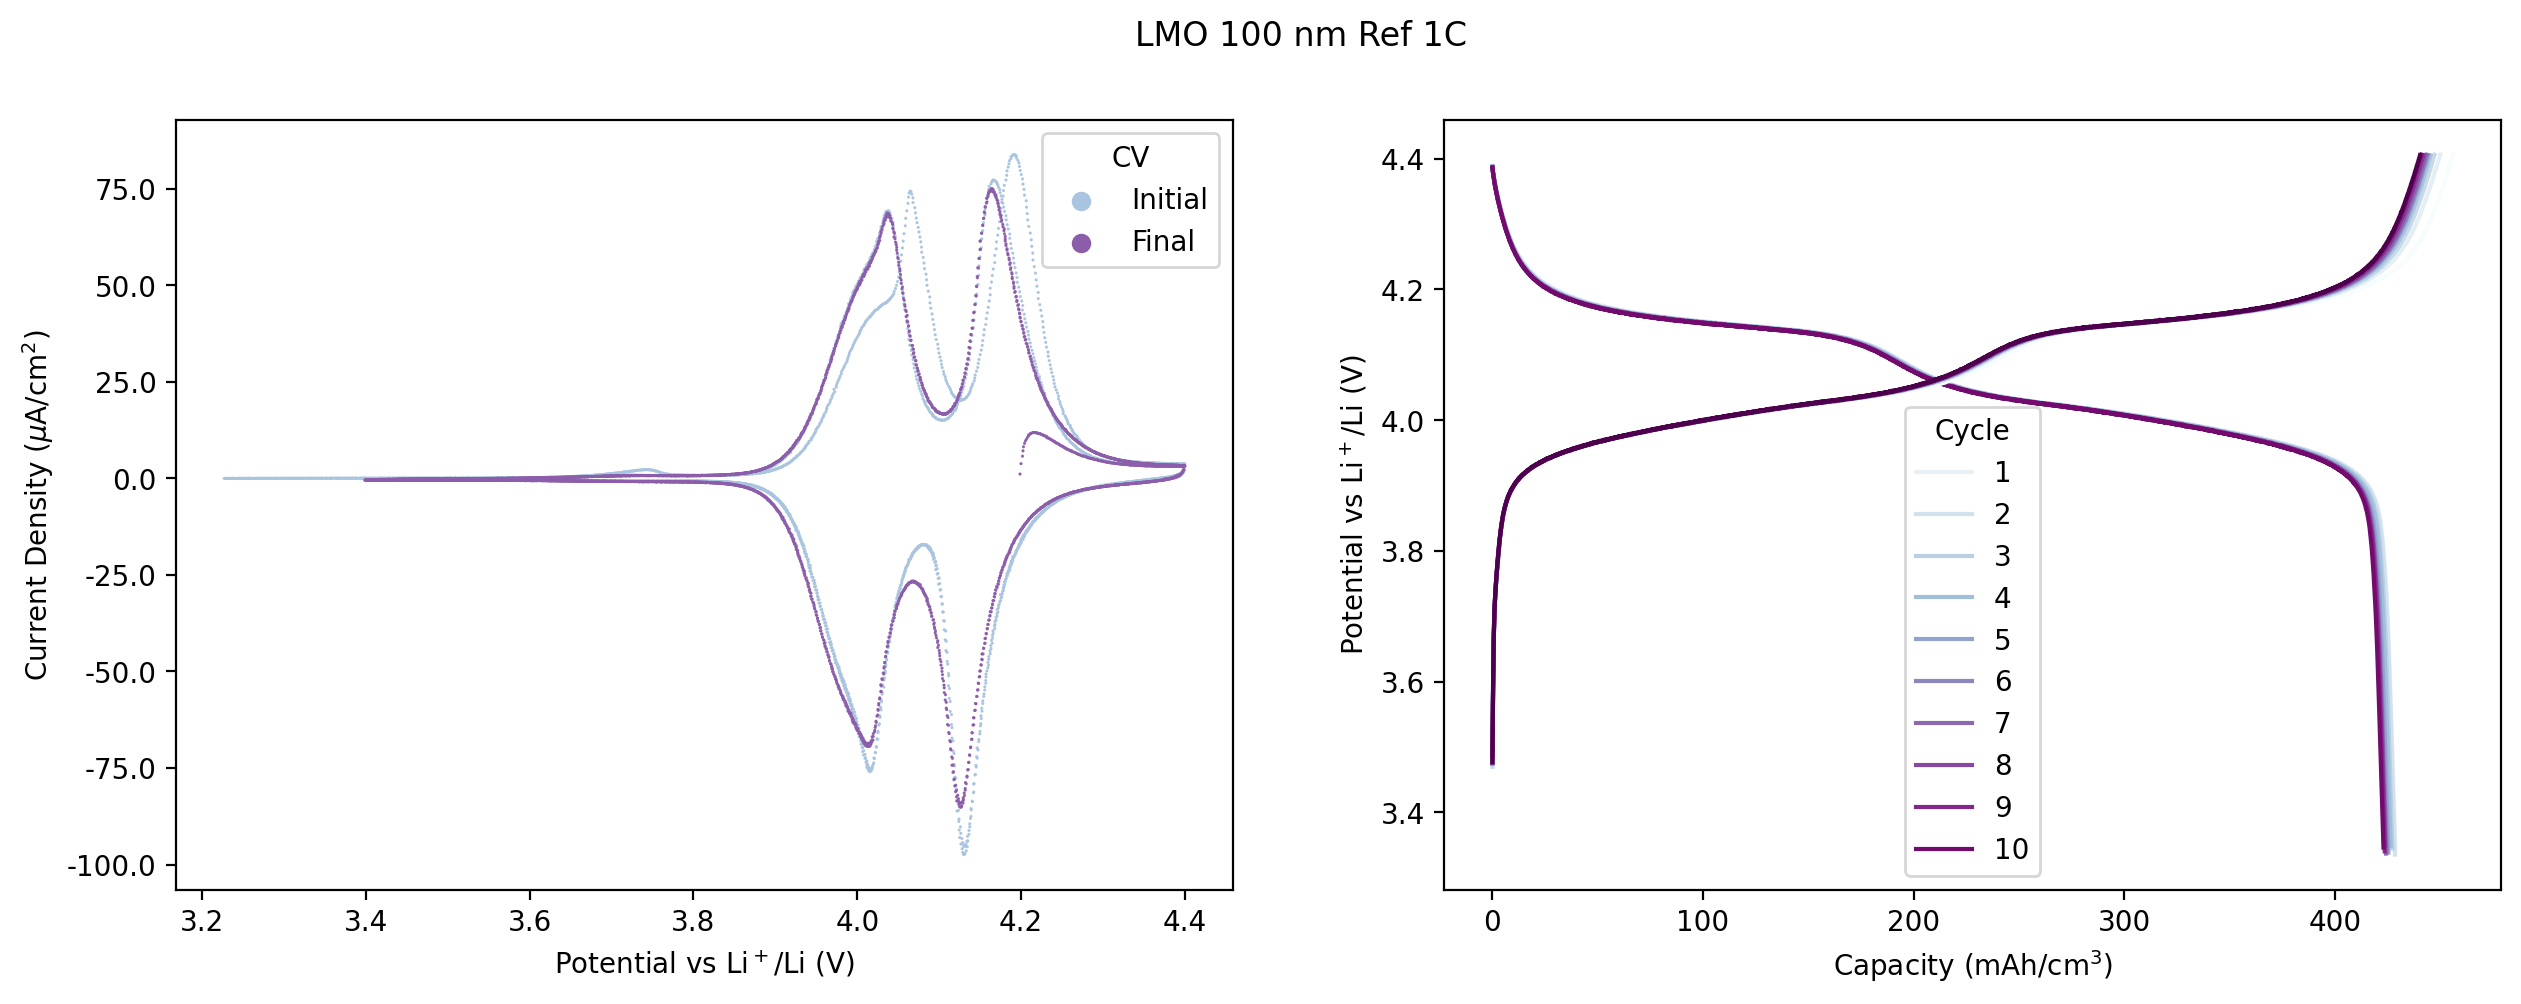

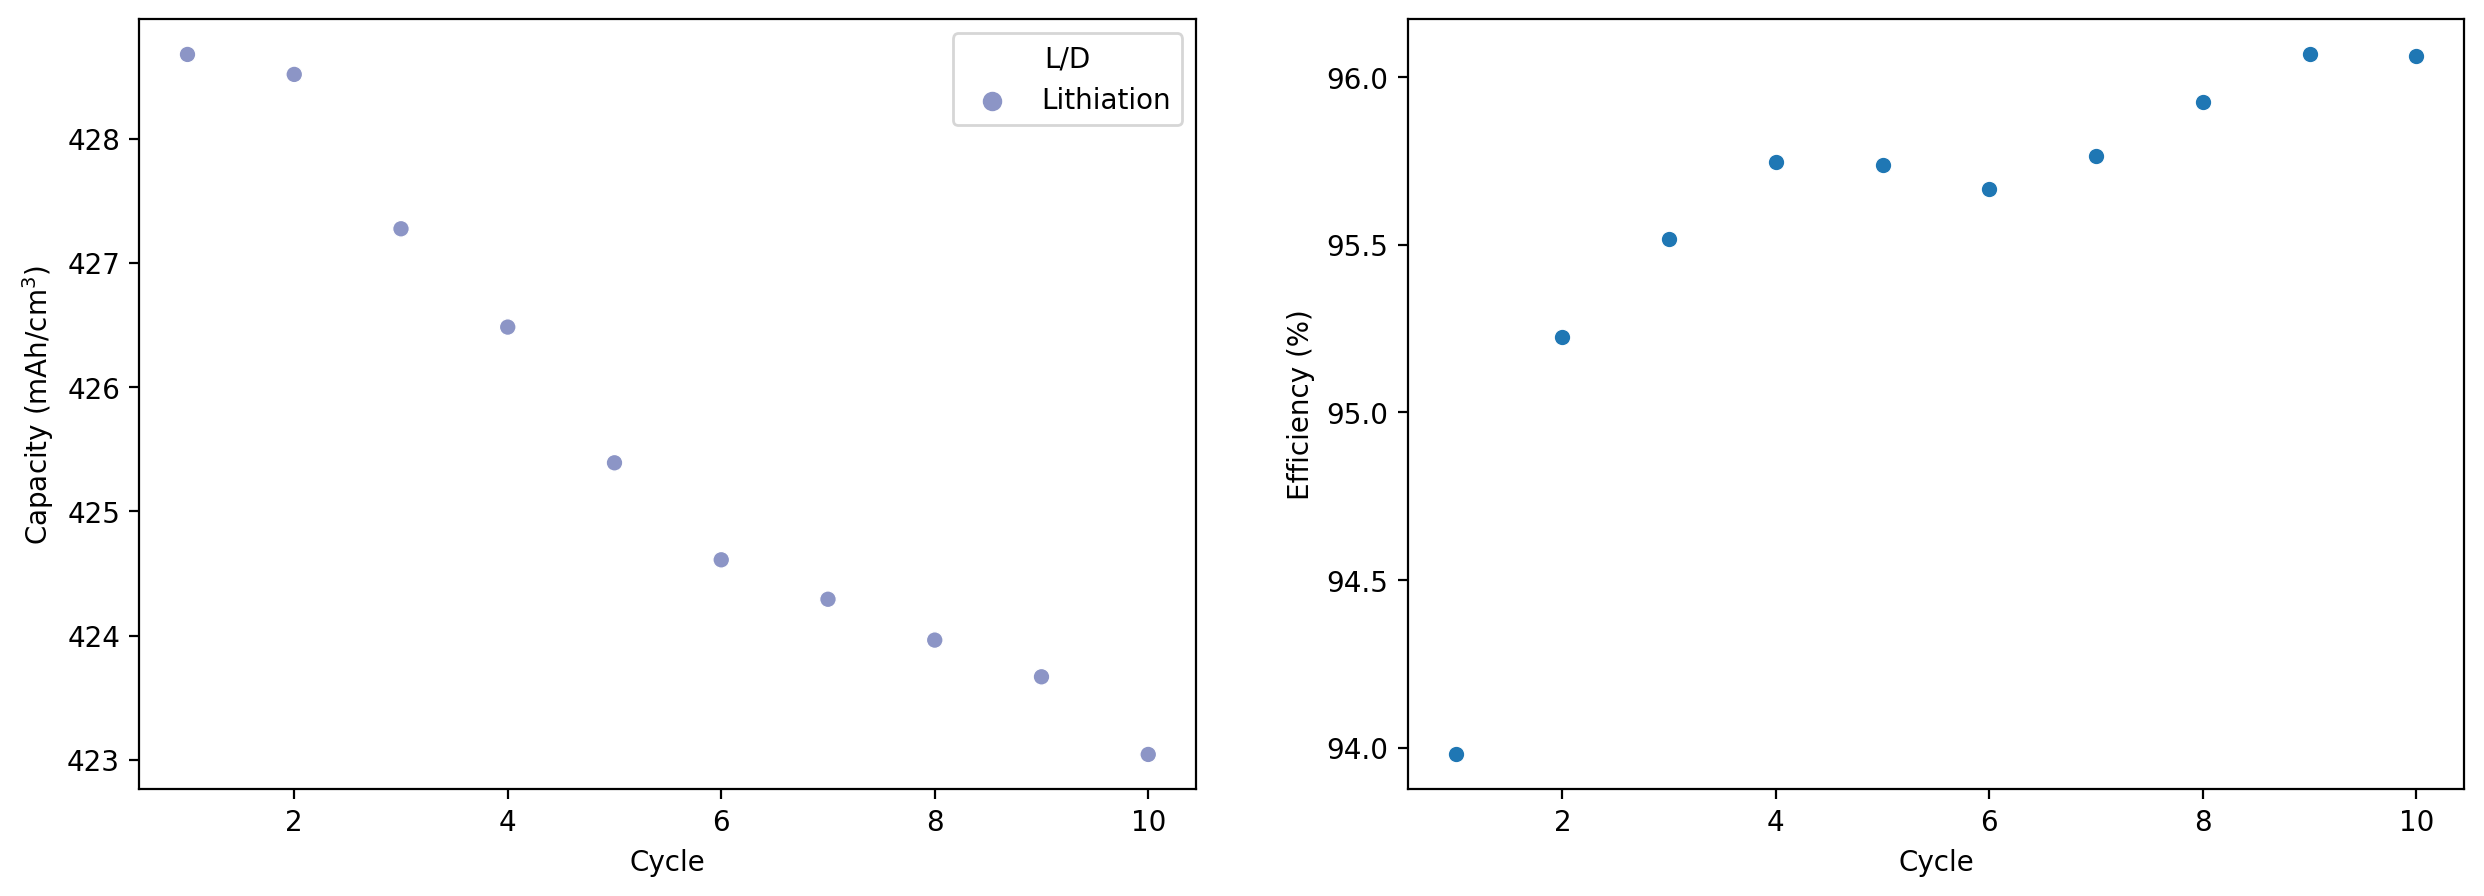

In [5]:
#Test LMO2h on Lab18 Pt

sample = 'LMO 100 nm Ref 1C'
sample_2c = 'LMO 90 nm Ref 2C'
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\L22\L22_01\1C'
path2 = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\L22\L22_01\2C'
setup_files(path)
area = np.pi *1**2
thick = 100 #nm
l22_01_1c = cc(path, area, thick, sample)
l22_01_2c = cc(path2, area, thick, sample_2c)
cc_plot(l22_01_1c, sample, 200)

# l22_01_1C_eis = eis(path, sample)
# eis_plot(l22_01_1C_eis, 100)

# l22_01_pitt = pitt(path, area, thick, 1, sample)
# pitt_plot(l22_01_pitt, sample)

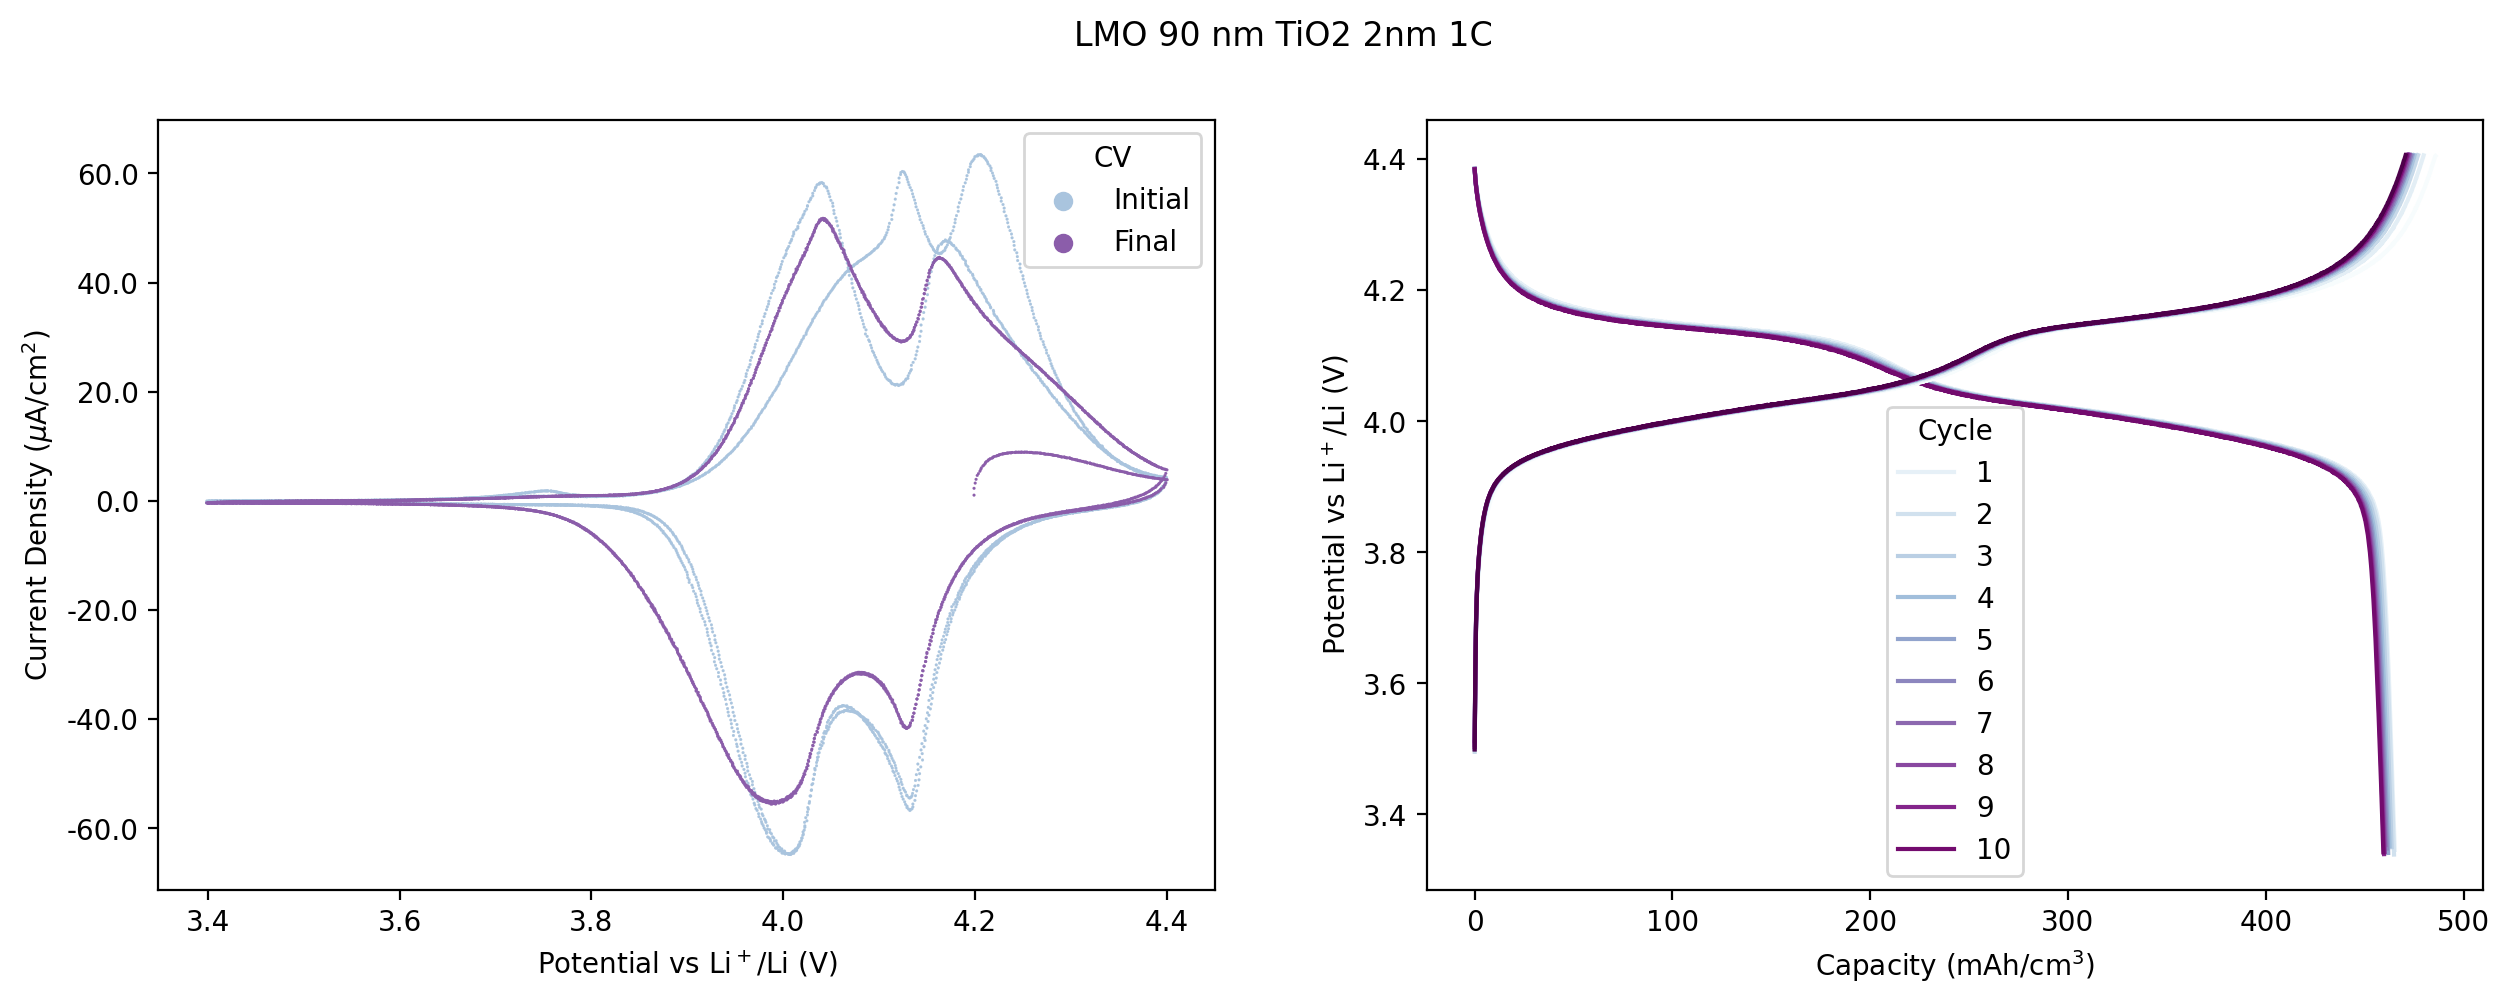

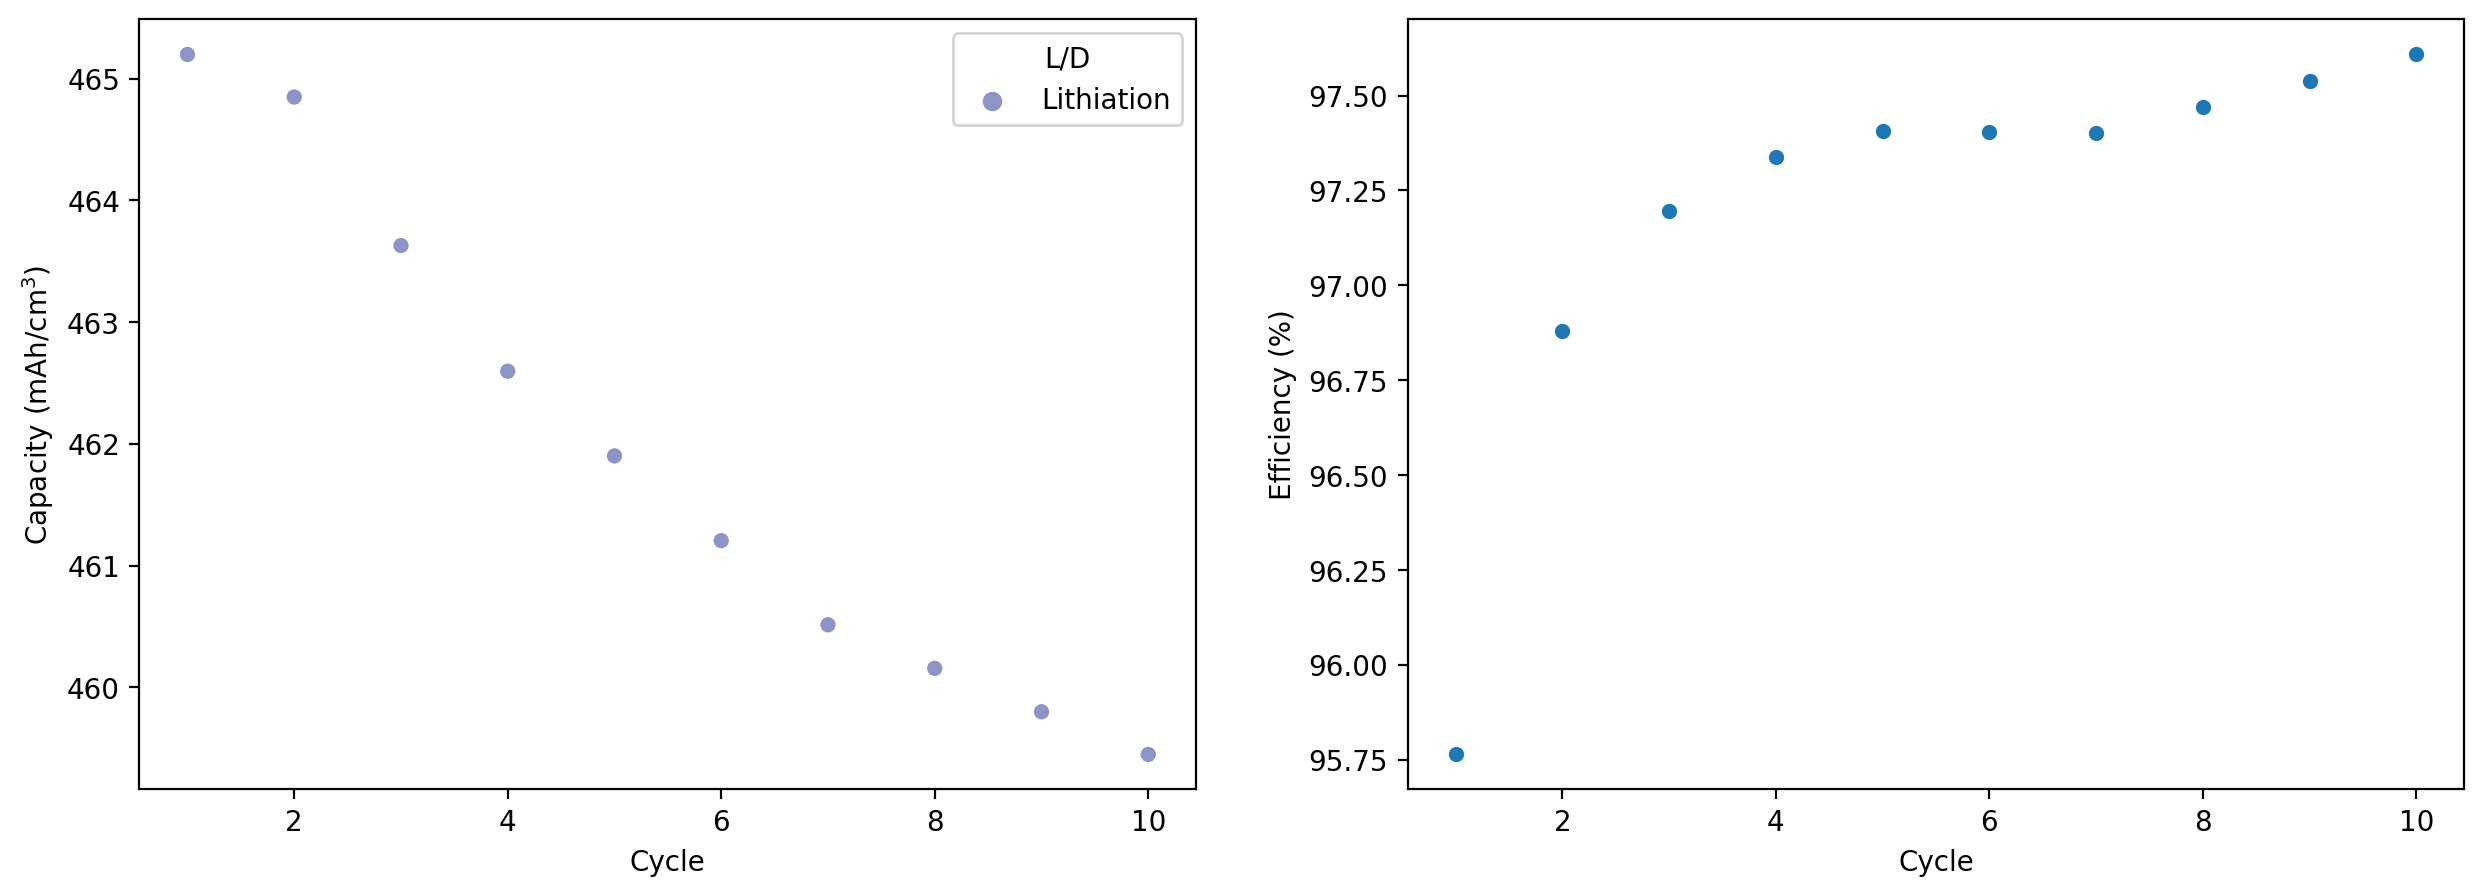

In [6]:
# LMO2h Lab18 ALD TiO2 18 cycles

sample = 'LMO 90 nm TiO2 2nm 1C'
sample_2c = 'LMO 90 nm TiO2 18 2C'
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\L22\L22_TiO2_18\1C'
path2 = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\L22\L22_TiO2_18\2C'
setup_files(path)
area = np.pi *1**2
thick = 90 #nm
l22_TiO2_18 = cc(path, area, thick, sample)
l22_TiO2_18_2c = cc(path2, area, thick, sample_2c)

cc_plot(l22_TiO2_18, sample, 200)

# l22_TiO2_18_1C_eis = eis(path, sample)

# l22_TiO2_18_pitt = pitt(path, area, thick, 1, sample)

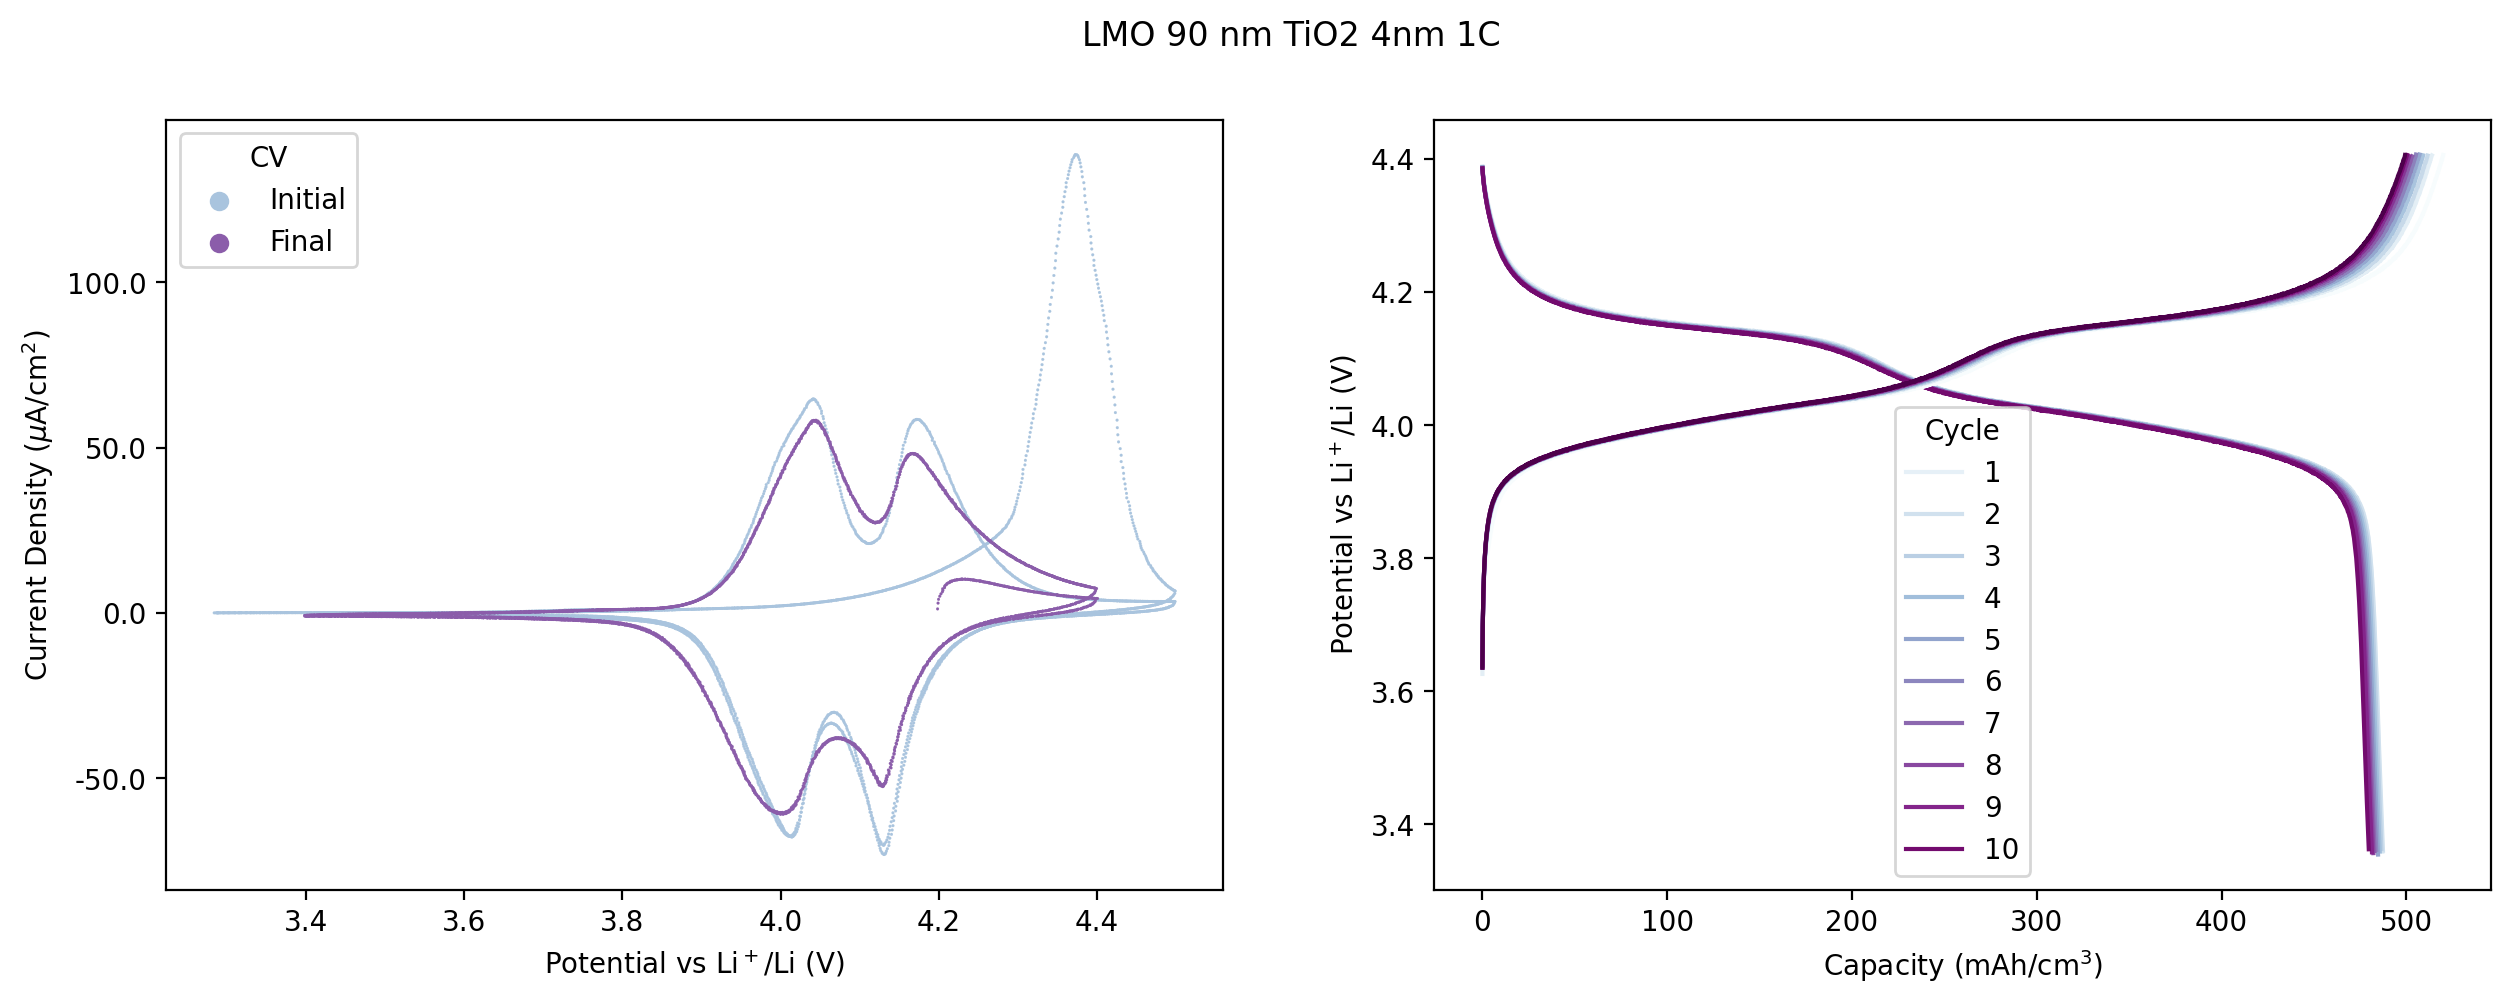

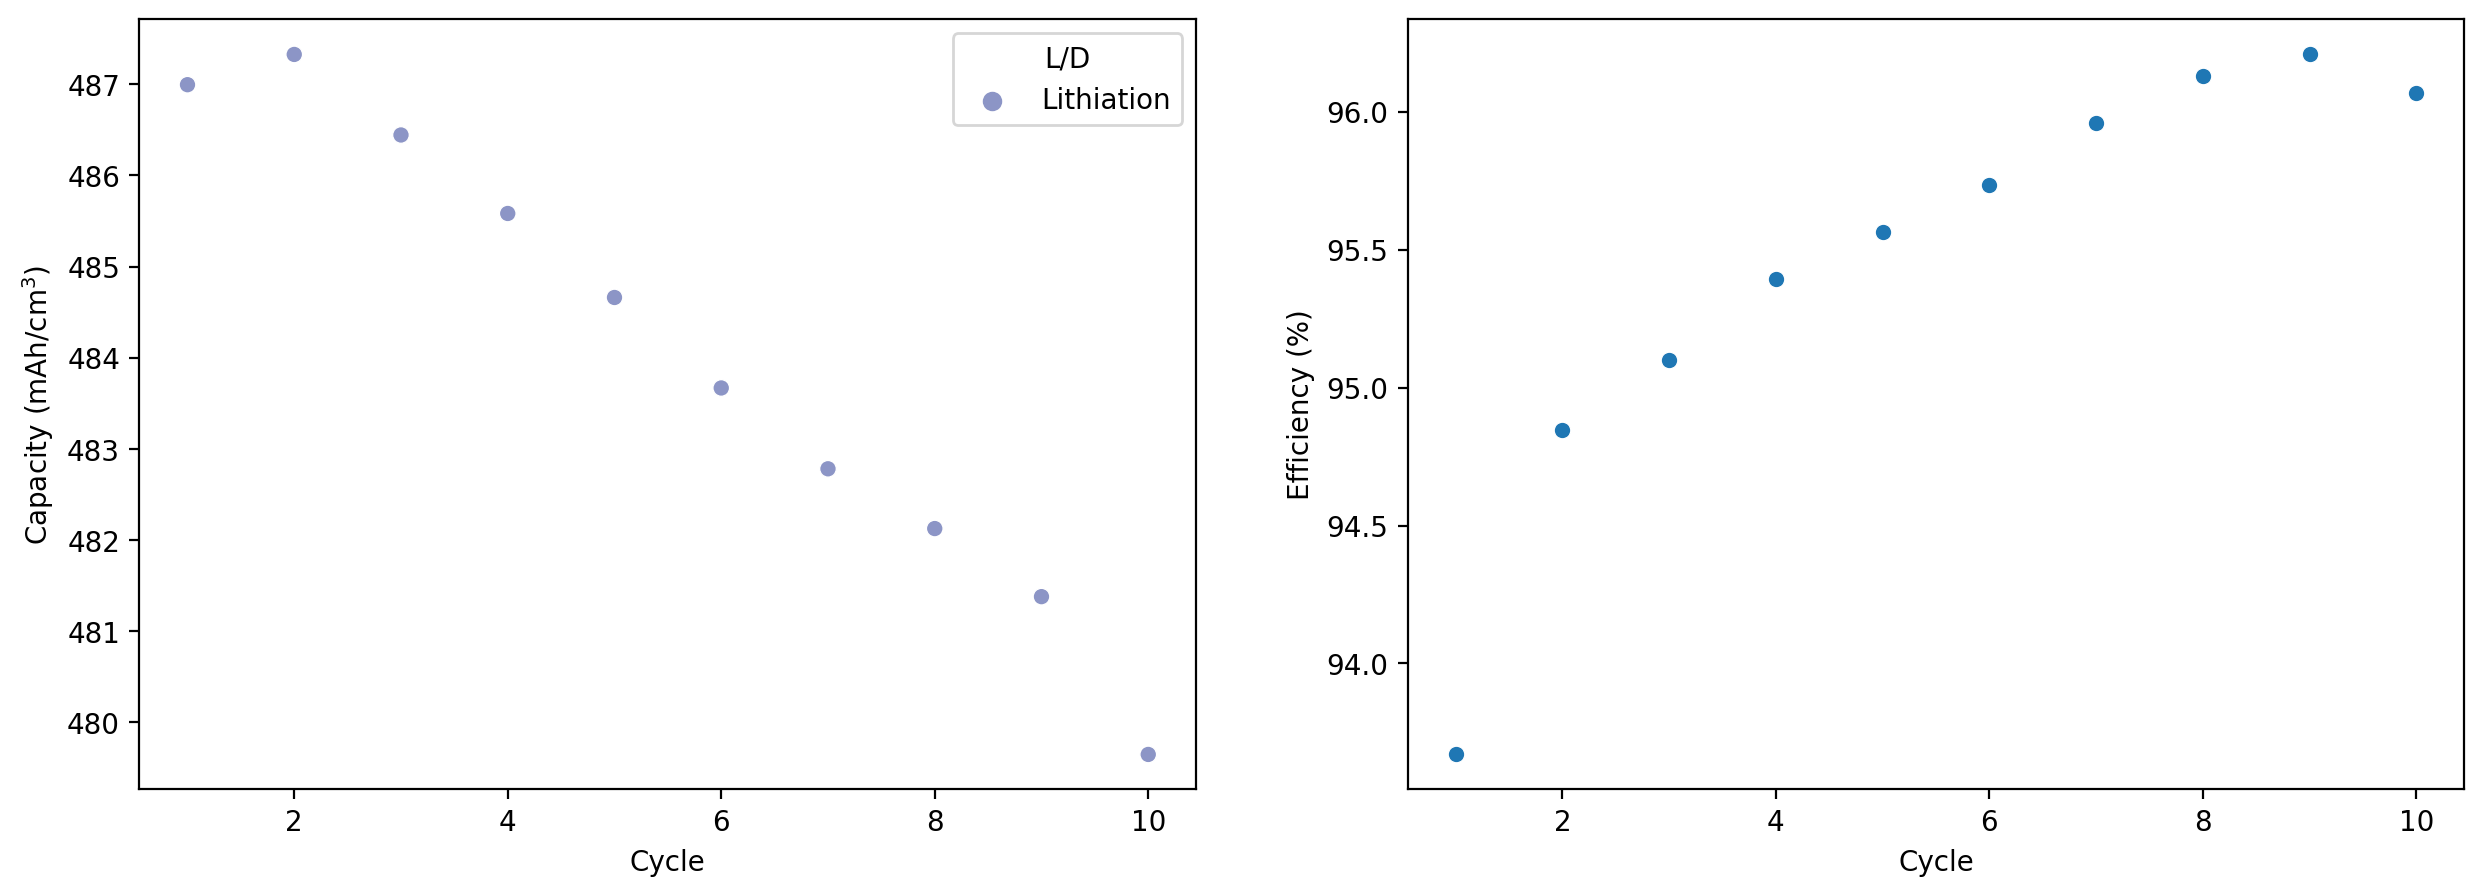

In [7]:
# LMO2h Lab18 ALD TiO2 54 cycles
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\L22\L22_TiO2_54\1C'
path2 = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\L22\L22_TiO2_54\2C'
sample = 'LMO 90 nm TiO2 4nm 1C'
sample2 = 'LMO 90 nm TiO2 4nm 2C'
setup_files(path)
setup_files(path2)
area = np.pi *1**2
thick = 90 #nm
l22_TiO2_54 = cc(path, area, thick, sample)
l22_TiO2_54_2c = cc(path2, area, thick, sample2)
cc_plot(l22_TiO2_54, sample, 200)
# l22_TiO2_54_1C_eis = eis(path, sample)
# l22_TiO2_54_pitt = pitt(path, area, thick, 1, sample)


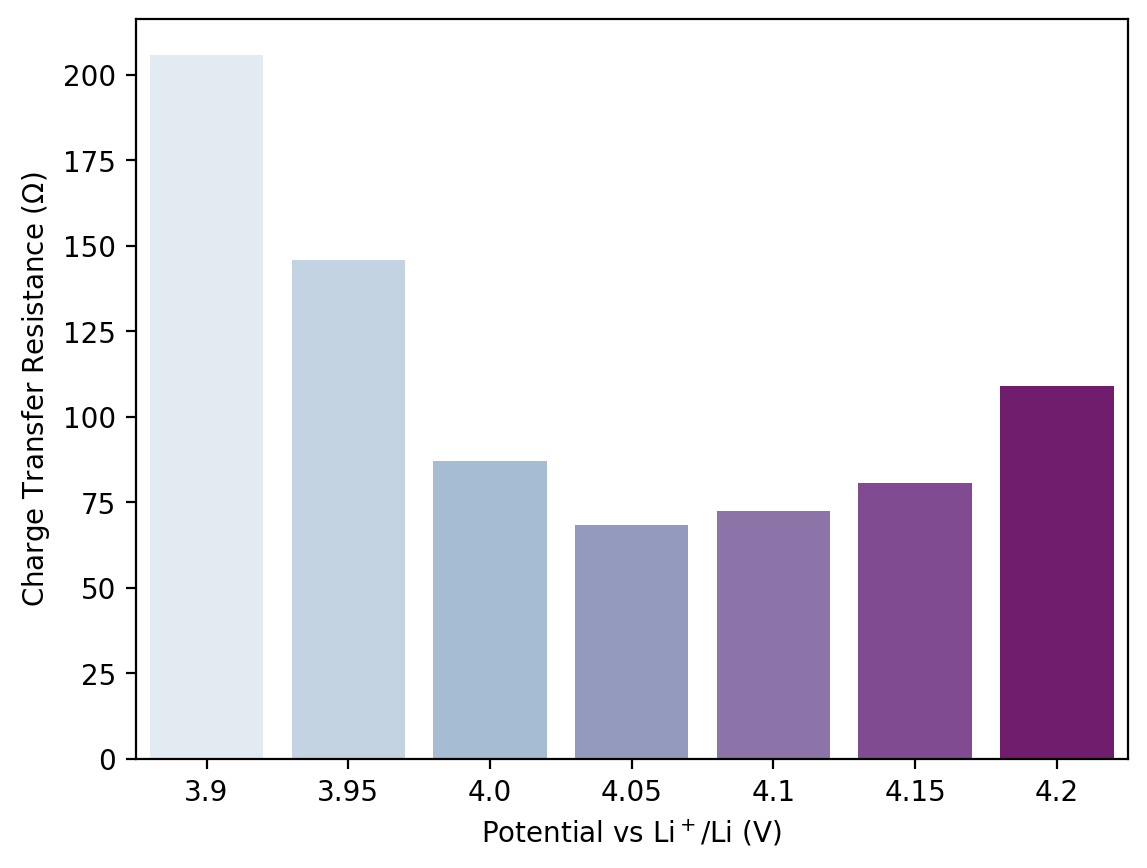

In [8]:
# LMO2h Lab18 ALD TiO2 90 cycles 7 nm
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\L22\L22_TiO2_90\1C'
path2 = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\L22\L22_TiO2_90\2C'
sample = 'LMO/TiO2 1'
sample2 = 'LMO/TiO2 1 2C'
setup_files(path)
setup_files(path2)
area = np.pi *1**2
thick = 90 #nm
l22_TiO2_90 = cc(path, area, thick, sample)
l22_TiO2_90_2c = cc(path2, area, thick, sample2)
l22_TiO2_90_1C_eis = eis(path, sample)
# l22_TiO2_90_pitt = pitt(path, area, thick, 1, sample)

# cc_plot(l22_TiO2_90, sample, 200)
eis_plot(l22_TiO2_90_1C_eis, 200)

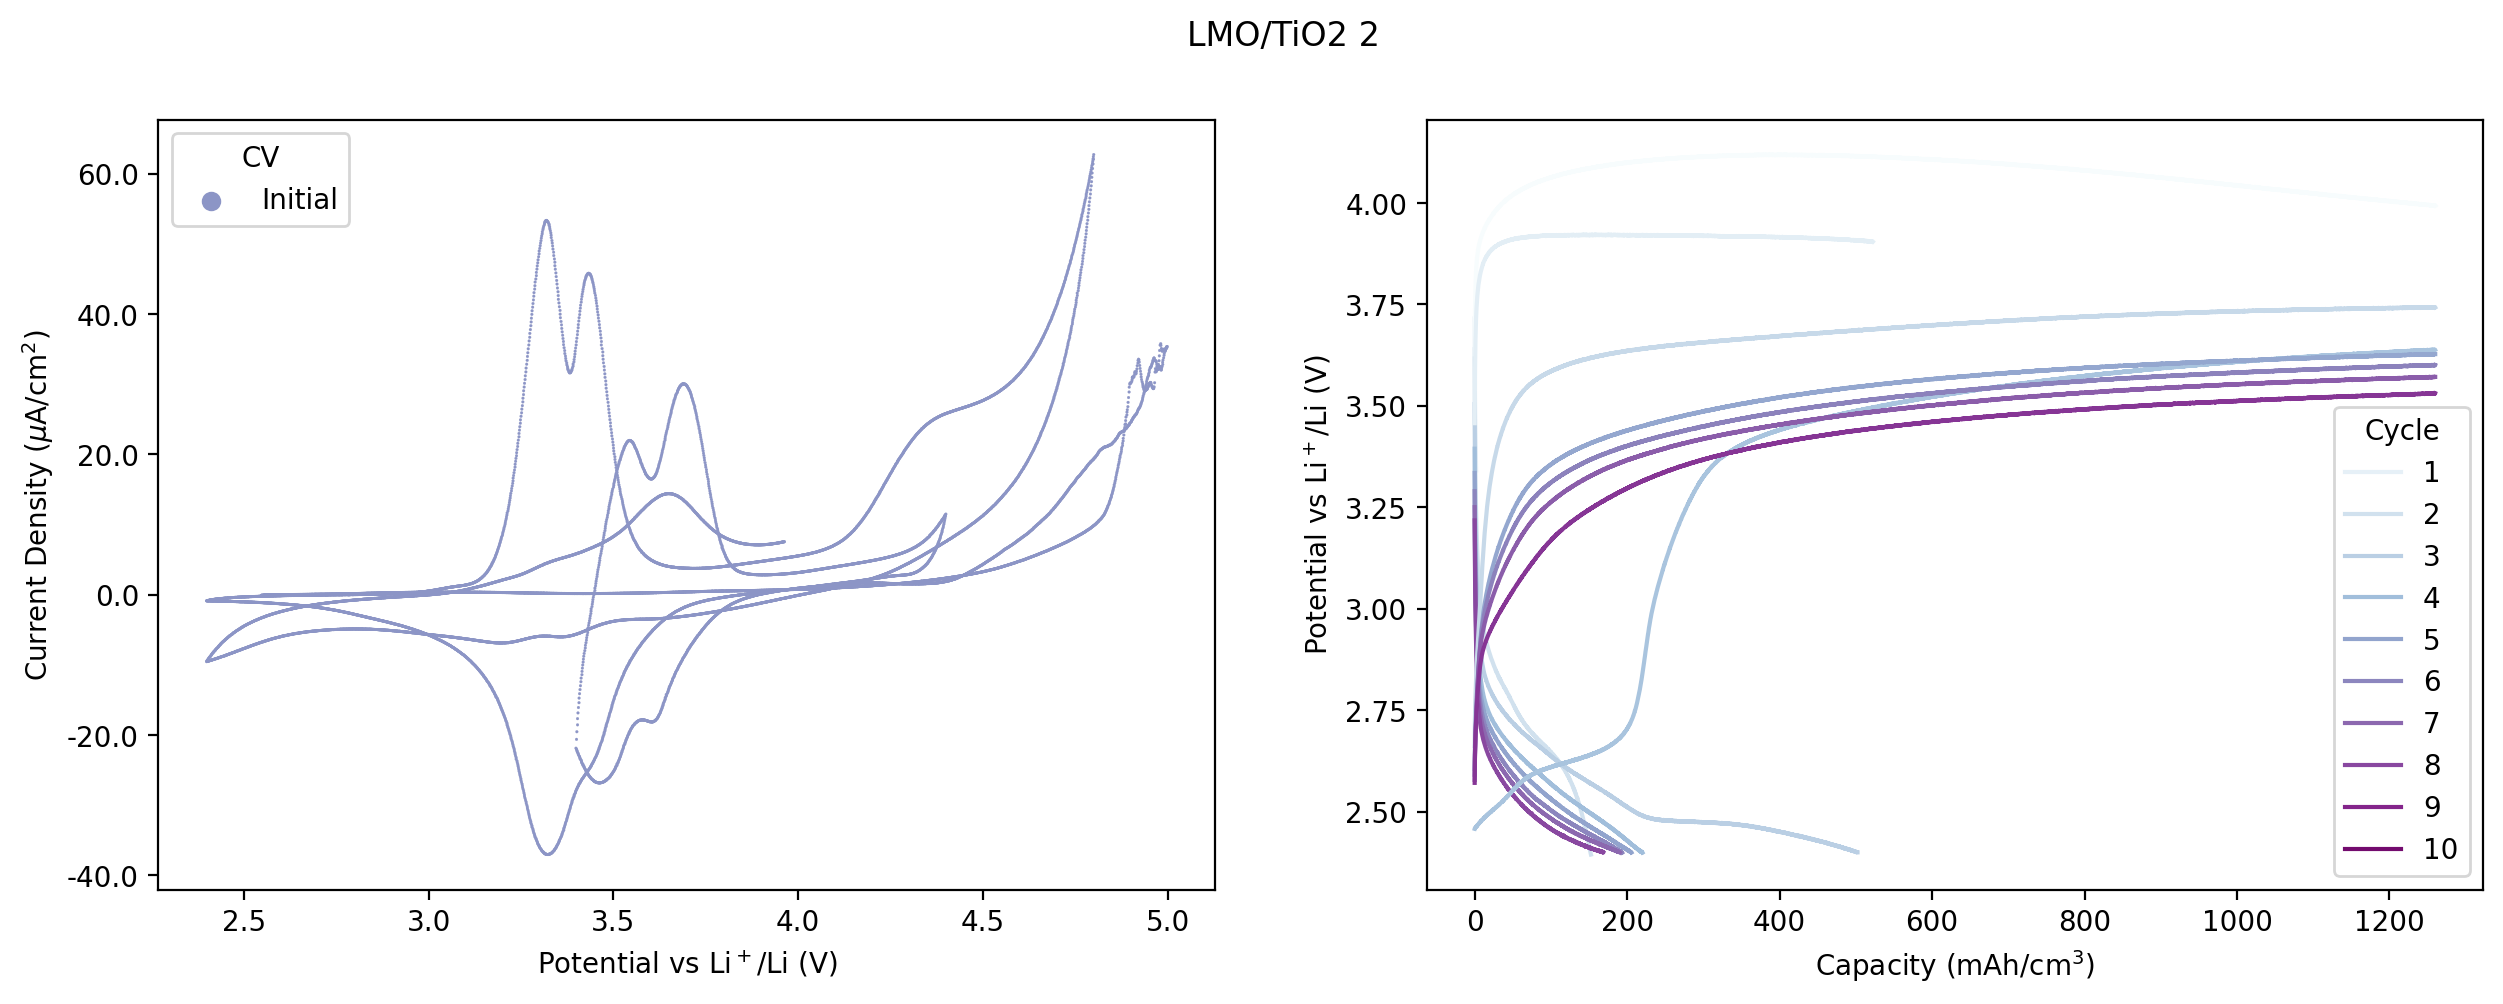

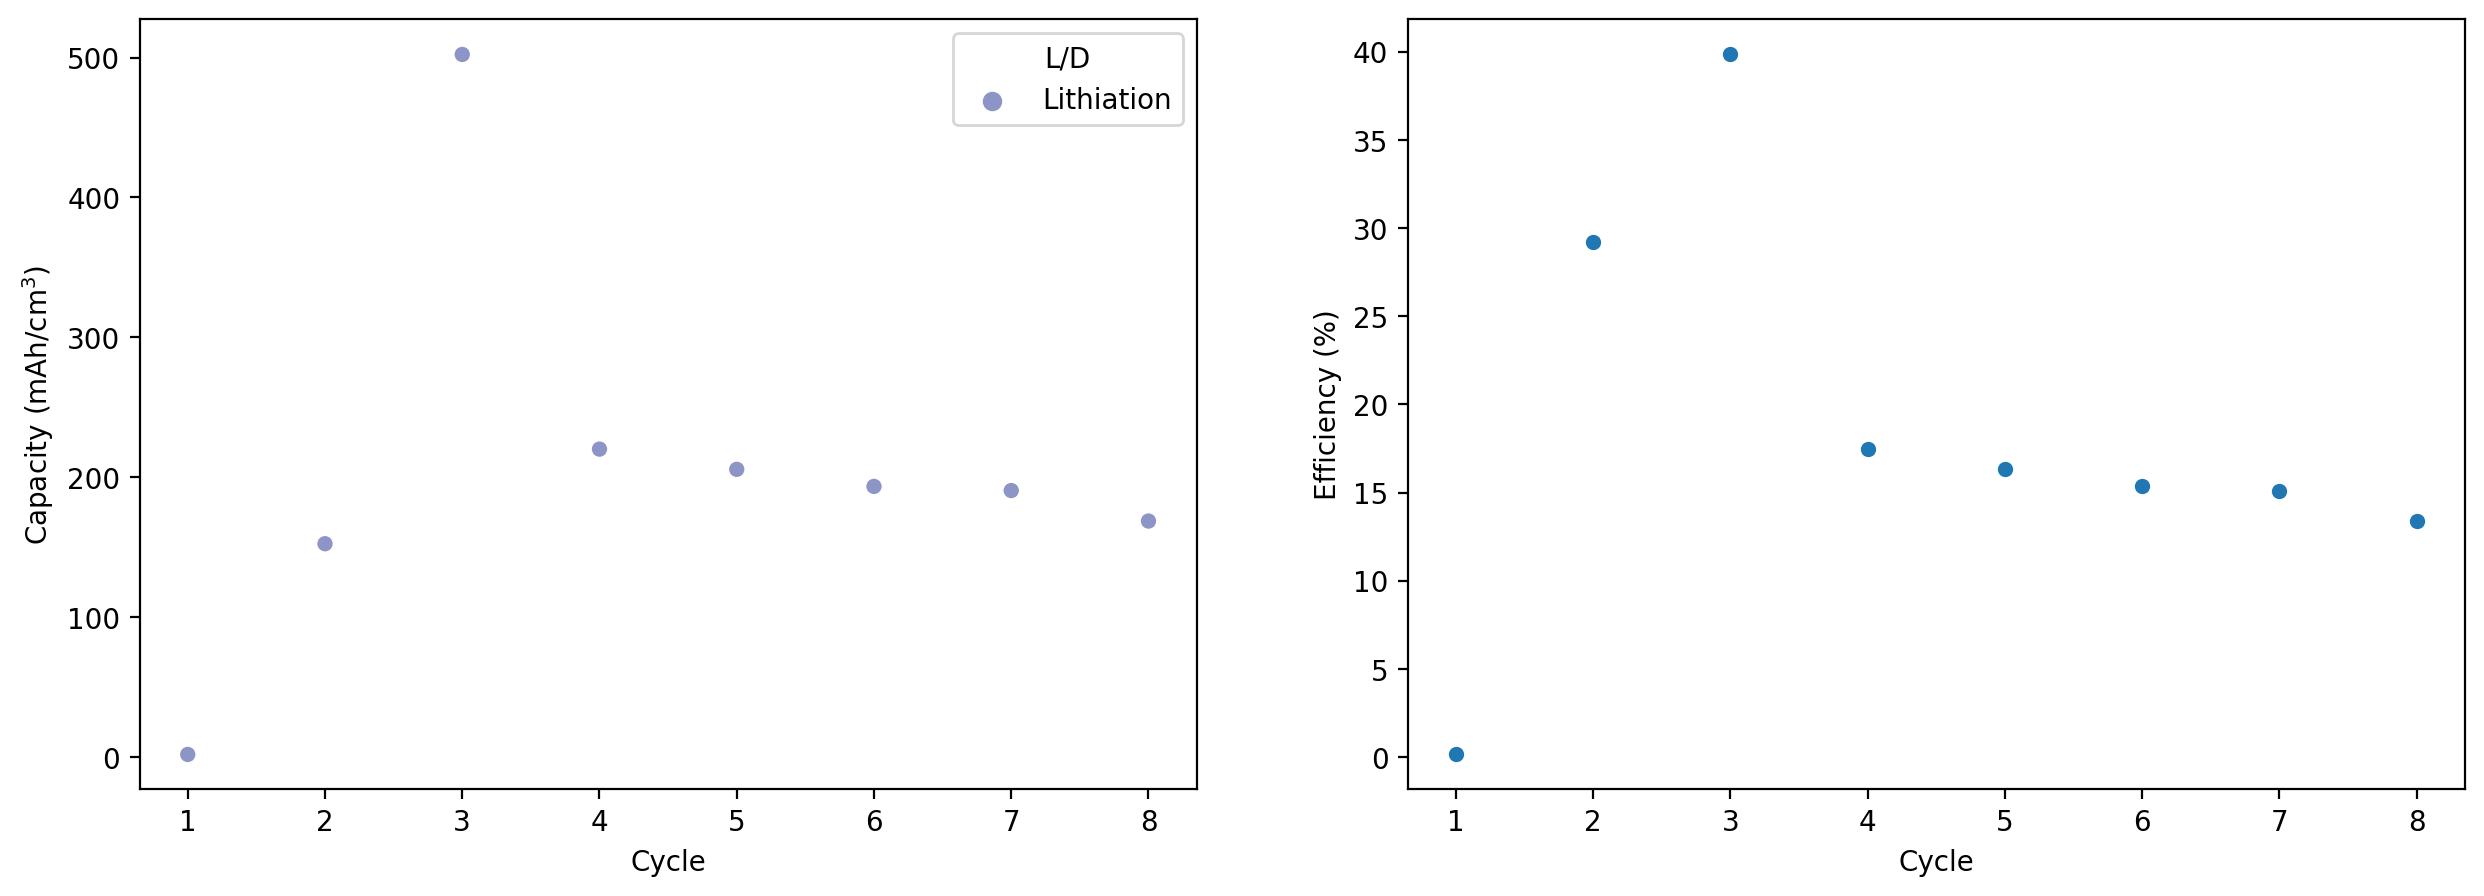

In [9]:
# LMO2h Lab18 ALD TiO2 90 cycles 7 nm SECOND SAMPLE
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\L23\L23_02\1C'
sample = 'LMO/TiO2 2'
# setup_files(path)
area = np.pi *1**2
thick = 90 #nm
l22_TiO2_90_2 = cc(path, area, thick, sample)
# l22_TiO2_90_1C_eis = eis(path, sample)
# l22_TiO2_90_pitt = pitt(path, area, thick, 1, sample)

cc_plot(l22_TiO2_90_2, sample, 200)


In [10]:
# Concatenating in one df to plot

cv = pd.DataFrame()
l = pd.DataFrame()
d = pd.DataFrame()
cap = pd.DataFrame()
eff = pd.DataFrame()
eis_df = pd.DataFrame()
pitt_df = pd.DataFrame()

# compare(l22_01_1c, l22_01_1C_eis,l22_01_pitt, True)
# compare(l22_TiO2_18, l22_TiO2_18_1C_eis, l22_TiO2_18_pitt, True)
# compare(l22_TiO2_54, l22_TiO2_54_1C_eis, l22_TiO2_54_pitt, True)
# compare(l22_TiO2_90, l22_TiO2_90_1C_eis, l22_TiO2_90_pitt, True)
# compare1(l22_TiO2_90, True)
# compare1(l22_TiO2_90_2, True)
on = False
compare1(l22_01_1c, on)
compare1(l22_01_2c, on)

# on = False
compare1(l22_TiO2_18, on)
compare1(l22_TiO2_18_2c, on)

# on = True
compare1(l22_TiO2_54, on)
compare1(l22_TiO2_54_2c, on)

on = True
compare1(l22_TiO2_90, on)
compare1(l22_TiO2_90_2c, on)

ValueError: Could not interpret input 'Potential vs Li$^+$/Li (V)'

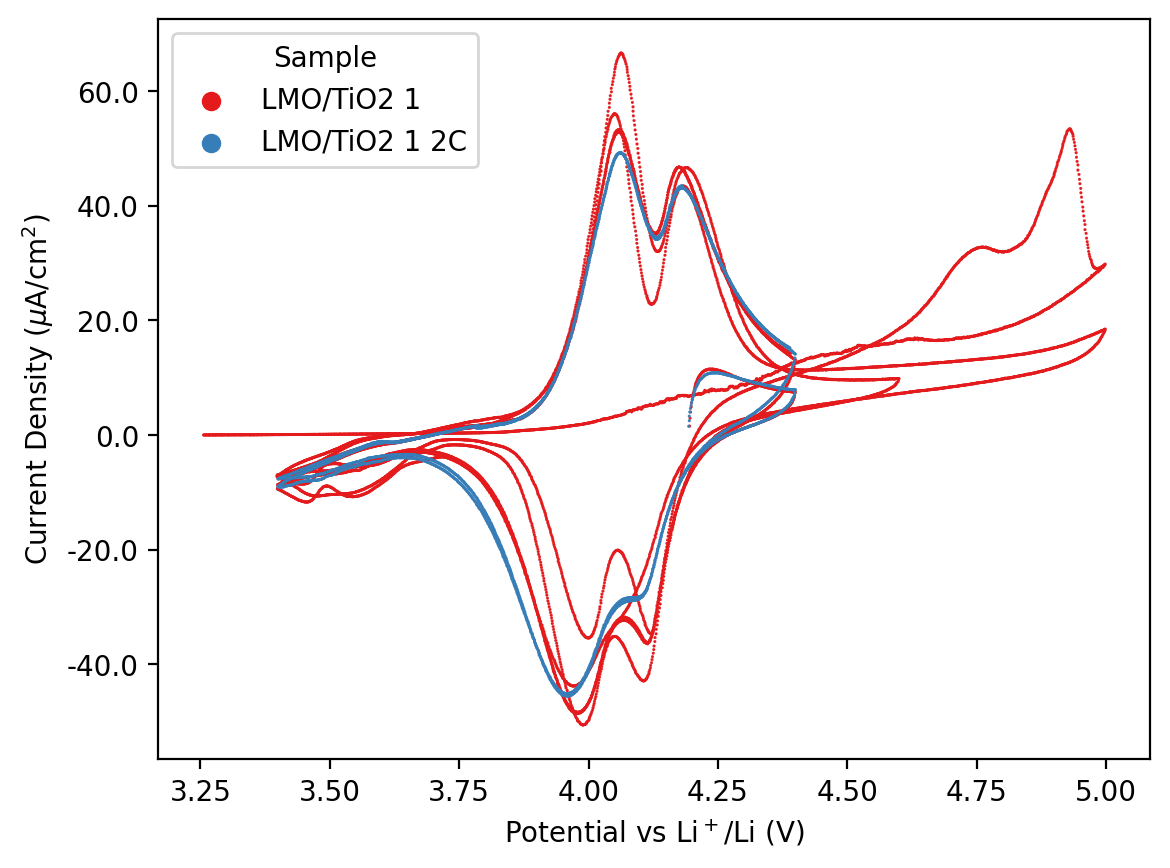

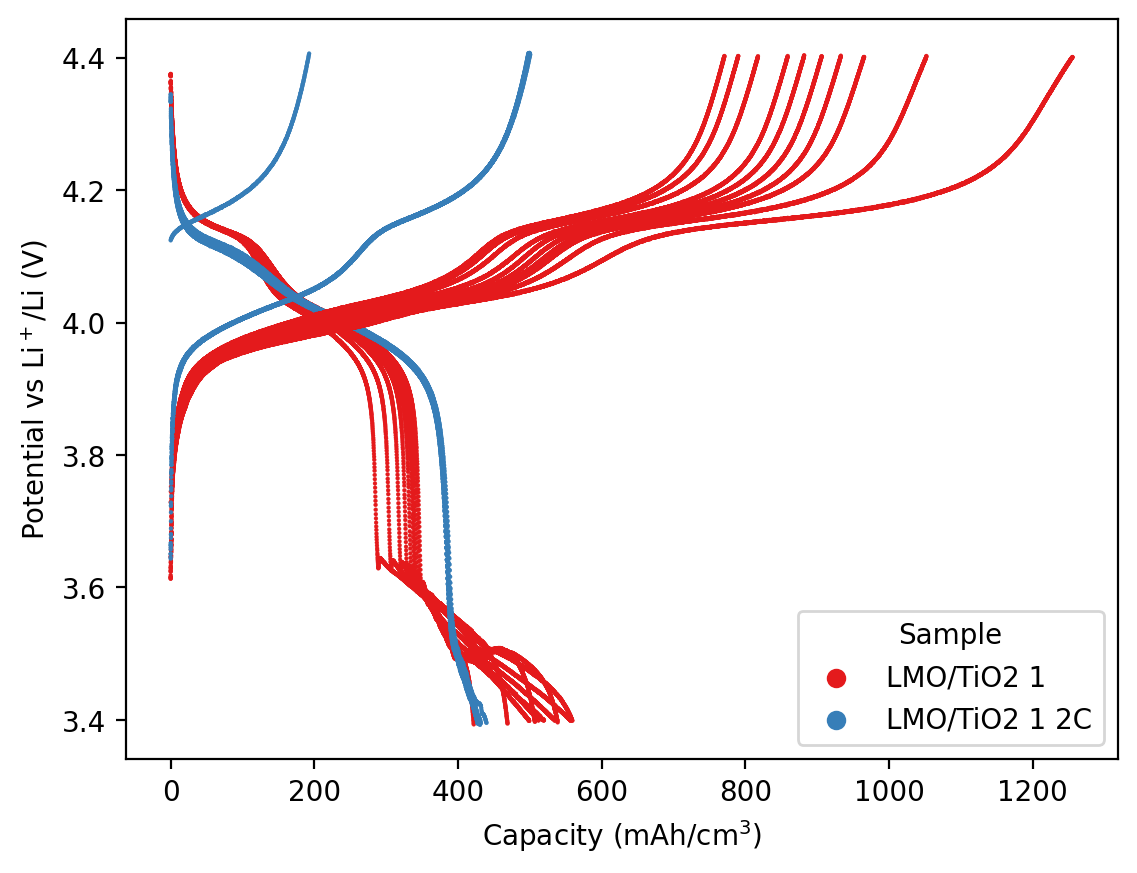

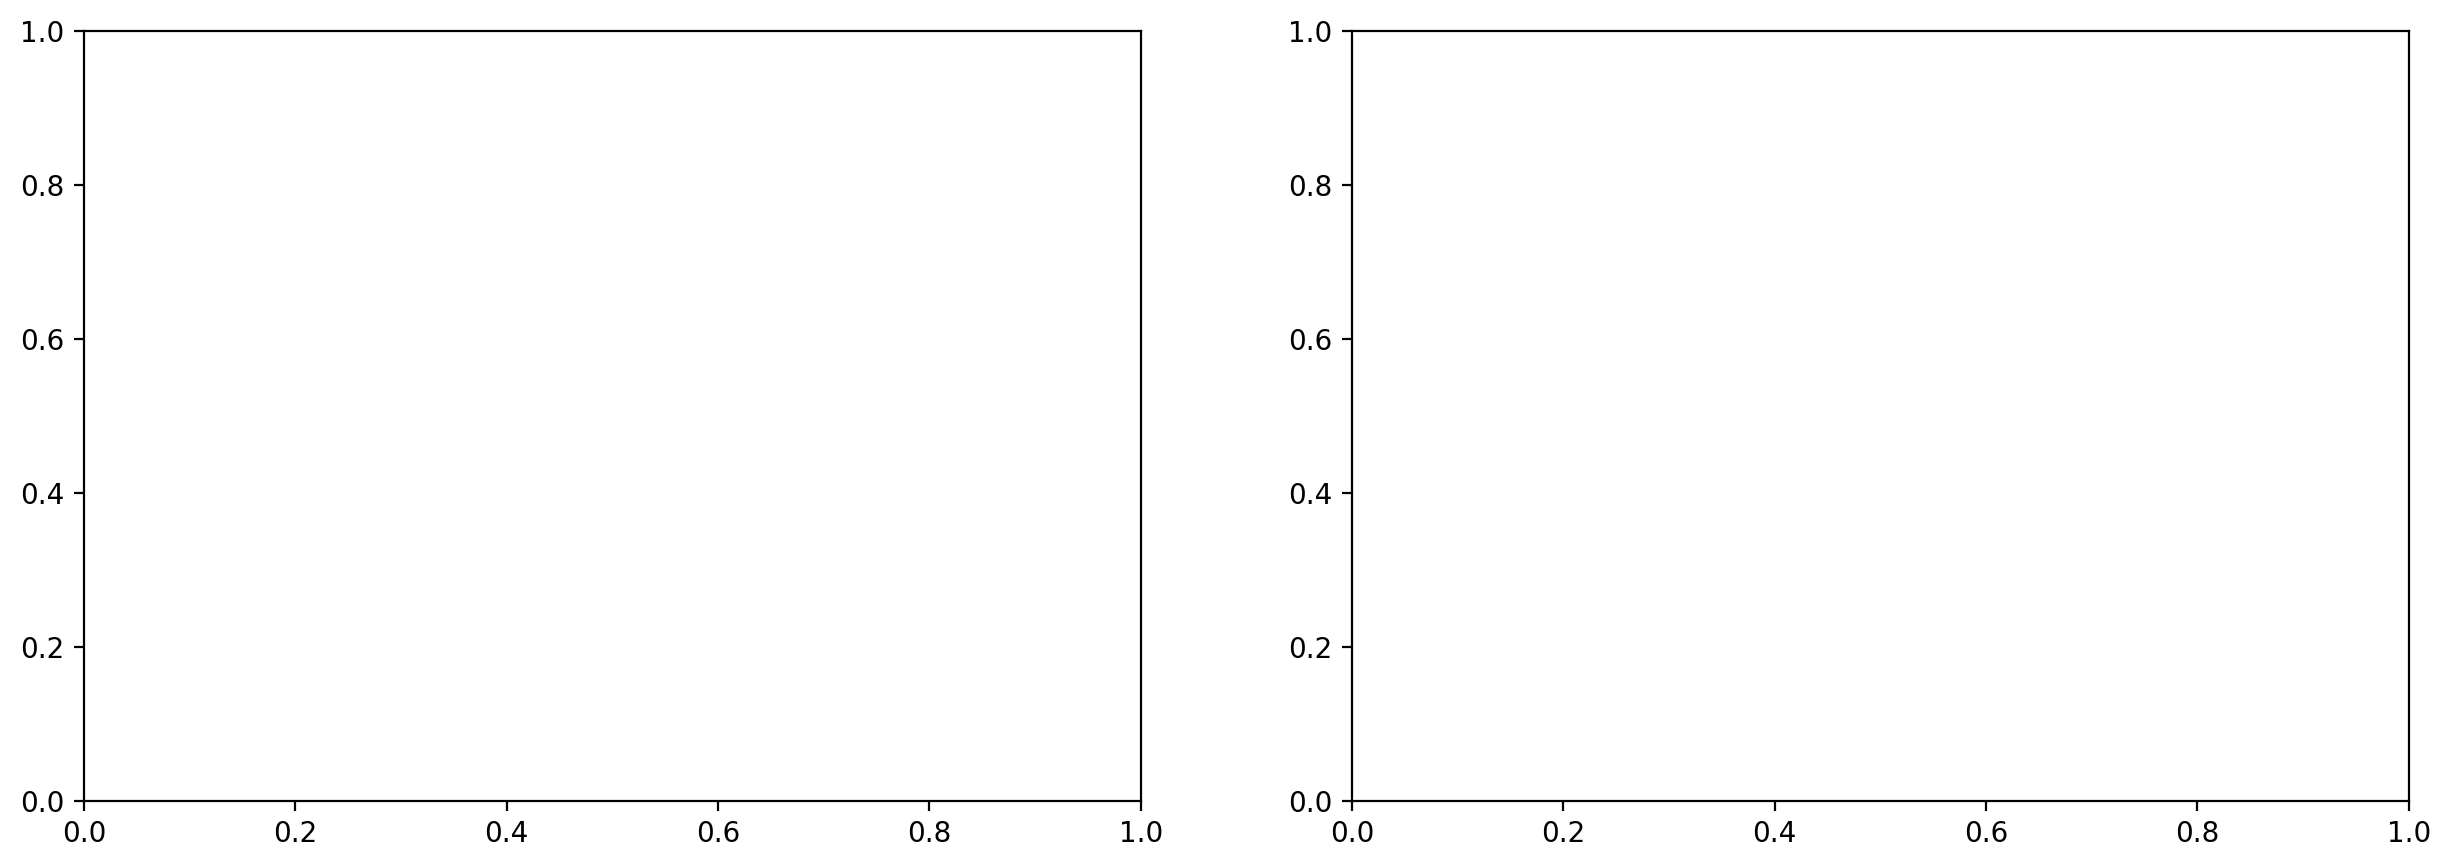

In [11]:
palette = 'Set1'
sns.set_palette(palette=palette, n_colors=4)

fig, ax = plt.subplots(dpi = 200)
sns.scatterplot(data = cv, x = 'Potential vs Li$^+$/Li (V)', y = 'Current Density ($\mu$A/cm$^2$)', hue = 'Sample', edgecolor = None, s = 1)
ax.yaxis.set_major_formatter(formatter)

fig, ax = plt.subplots(dpi = 200)
sns.scatterplot(data = l, x = 'Capacity_calc', y = 'Potential vs Li$^+$/Li (V)', hue = 'Sample', edgecolor = None, s = 2)
sns.scatterplot(data = d, x = 'Capacity_calc', y = 'Potential vs Li$^+$/Li (V)', hue = 'Sample', legend = False, edgecolor = None, s = 2)
ax.set_xlabel('Capacity (mAh/cm$^3$)')

# fig, ax = plt.subplots(dpi = 200)
# sns.scatterplot(data = cap, x = 'Cycle', y = 'Capacity (mAh/cm$^3$)', hue = 'Sample', style='Sample', edgecolor = None, s =80, legend = True)

# fig, ax = plt.subplots(dpi = 200)
# sns.scatterplot(data = eff, x = 'Cycle', y = 'Efficiency (%)', hue = 'Sample', style ='Sample', edgecolor = None, s =80)
# ax.set_ylim(30,100)

fig, ax = plt.subplots(1,2, figsize = (15,5), dpi = 200)
sns.barplot(data = eis_df, x = 'Potential vs Li$^+$/Li (V)', y = 'Charge Transfer Resistance ($\Omega$)', hue = 'Sample', ax = ax[0])
# sns.barplot(data = eis_df, x = 'Potential vs Li$^+$/Li (V)', y = 'Double Layer Capacitance ($\mu$F)', hue = 'Sample', ax = ax[1]) # Electrolyte Resistance ($\Omega$) 'Double Layer Capacitance ($\mu$F)'
# ax[1].yaxis.set_major_formatter(formatter)
# ax[1].legend().set_visible(False)
# 
# fig, ax = plt.subplots(1,2, dpi =200, figsize = (15,5))
# sns.scatterplot(data = pitt_df, x = col2[0], y = col2[1], ax = ax[0], hue = 'Sample', style = 'Sample', s = 70)
# sns.scatterplot(data = pitt_df, x = col2[0], y = col2[3],  hue = 'Sample', style = 'Sample', s = 70, legend = False)
# ax[0].set_yscale('log')



In [ ]:
# Comparison


# cv = pd.concat([l22_01_1c[0],  l22_TiO2_18[0],  l22_TiO2_54[0]], ignore_index=True) #l22_TiO2_18_2c[0], l22_01_2c[0],
# l = pd.concat([l22_01_1c[1], l22_TiO2_18[1],  l22_TiO2_54[1]], ignore_index=True) # l22_TiO2_18_2c[1], l22_01_2c[1]
# d = pd.concat([l22_01_1c[2],  l22_TiO2_18[2],  l22_TiO2_54[2]], ignore_index=True) # l22_TiO2_18_2c[2], l22_01_2c[2],
# cap = pd.concat([l22_01_1c[3], l22_TiO2_18[3],  l22_TiO2_54[3]], ignore_index=True) # l22_TiO2_18_2c[3], , l22_01_2c[3]
# eff = pd.concat([l22_01_1c[4],  l22_TiO2_18[4], l22_TiO2_54[4]], ignore_index=True) # , l22_TiO2_18_2c[4] # l22_01_2c[4],


# eis_df = pd.concat([l22_01_1C_eis[0], l22_TiO2_18_1C_eis[0], l22_TiO2_54_1C_eis[0]], ignore_index=True)

# pitt_df = pd.concat([l22_01_pitt[1], l22_TiO2_18_pitt[1], l22_TiO2_54_pitt[1]], ignore_index=True)


# fig, ax = plt.subplots(dpi = 200)
# sns.scatterplot(data = cv, x = 'Potential vs Li$^+$/Li (V)', y = 'Current Density ($\mu$A/cm$^2$)', hue = 'Sample', edgecolor = None, s = 3)
# ax.yaxis.set_major_formatter(formatter)

# fig, ax = plt.subplots(dpi = 200)
# sns.scatterplot(data = l, x = 'Capacity_calc', y = 'Potential vs Li$^+$/Li (V)', hue = 'Sample', edgecolor = None, s = 5)
# sns.scatterplot(data = d, x = 'Capacity_calc', y = 'Potential vs Li$^+$/Li (V)', hue = 'Sample', legend = False, edgecolor = None, s = 5)
# ax.set_xlabel('Capacity (mAh/cm$^3$)')

# fig, ax = plt.subplots(dpi = 200)
# sns.scatterplot(data = cap, x = 'Cycle', y = 'Capacity (mAh/cm$^3$)', hue = 'Sample', style='Sample', edgecolor = None)

# fig, ax = plt.subplots(dpi = 200)
# sns.scatterplot(data = eff, x = 'Cycle', y = 'Efficiency (%)', hue = 'Sample', style ='Sample', edgecolor = None, s =50)
# ax.set_ylim(90,100)

# fig, ax = plt.subplots(1,2, figsize = (15,5), dpi = 200)
# sns.barplot(data = eis_df, x = 'Potential vs Li$^+$/Li (V)', y = 'Charge Transfer Resistance ($\Omega$)', hue = 'Sample', ax = ax[0])
# sns.barplot(data = eis_df, x = 'Potential vs Li$^+$/Li (V)', y = 'Double Layer Capacitance ($\mu$F)', hue = 'Sample', ax = ax[1]) # Electrolyte Resistance ($\Omega$) 'Double Layer Capacitance ($\mu$F)'
# ax[1].yaxis.set_major_formatter(formatter)

# fig, ax = plt.subplots(1,2, dpi =200, figsize = (15,5))
# sns.scatterplot(data = pitt_df, x = col2[0], y = col2[1], ax = ax[0], hue = 'Sample')
# sns.scatterplot(data = pitt_df, x = col2[0], y = col2[3],  hue = 'Sample')
# ax[0].set_yscale('log')

# palette = 'cividis_r'
# sns.set_palette(palette=palette, n_colors=3)
# # print(len(cv))
# # eis_df